# Trabajo Obligatorio - Análisis de una Serie Temporal de Ventas 

-----

## Estudiantes: Javier Ramas (107758) - Antonia Rodriguez (260101) - Sebastián Zanotta (252045)

## Objetivo:

Analizar el dataset de una empresa ficticia que comercializa productos online, algo similar a lo que hace Amazon.

Utilizaremos la biblioteca `astsa`  como hasta ahora, y en algunos casos la biblioteca `forecast` que tiene algunas funciones que simplifican este proceso. 

In [1]:
#install.packages("forecast")
#install.packages("astsa")
#install.packages("ggplot2")
#install.packages("tidyverse")
#install.packages("dplyr")
library(forecast)
library(astsa)
library(ggplot2)
library(tidyverse)
lag <- stats::lag
#library(magrittr)
#library(openxlsx)
library(dplyr)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


Attaching package: ‘astsa’


The following object is masked from ‘package:forecast’:

    gas


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  3.0.3     ✔ purrr   0.3.4
✔ tidyr   1.1.0     ✔ dplyr   1.0.0
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.0.3     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
ventas <- read.csv("Global Superstore.csv", sep = ",")
head(ventas,3)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,City,State,⋯,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,⋯,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wireless Headset System,2309.650,7,0.0,762.1845,933.57,Critical
2,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,⋯,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
3,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,⋯,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


El dataset se compone de 24 columnas y 51290 filas que representan un pedido cada una, se presentan los datos de ventas comenzando en el año 2011 y finalizando en el 2015. A continuación se presentan los nombres de las columnas que componen las variables de cada pedido. De estas utilizaremos para nuestro análisis con la fecha de compra "Order.Date" y el valor de la venta "Sales".

In [3]:
colnames(ventas)

[1] "Row.ID"         "Order.ID"       "Order.Date"     "Ship.Date"     
 [5] "Ship.Mode"      "Customer.ID"    "Customer.Name"  "Segment"       
 [9] "City"           "State"          "Country"        "Postal.Code"   
[13] "Market"         "Region"         "Product.ID"     "Category"      
[17] "Sub.Category"   "Product.Name"   "Sales"          "Quantity"      
[21] "Discount"       "Profit"         "Shipping.Cost"  "Order.Priority"

A continuación identificaremos los valores faltantes y a que varible pertenecen para luego eliminarlos y que no afecten la intregridad de los datos ni el análisis posterior.

In [4]:
sum(is.na(ventas))

[1] 41296

In [5]:
ColumnasconNA<-""
for (i in c(1:ncol(ventas)))
{
  len<-length(grep("TRUE",is.na(ventas[,i])))
  if(len > 0){
    ColumnasconNA<-paste(colnames(ventas[i]),":",len,ColumnasconNA)
  }
}
ColumnasconNA

[1] "Postal.Code : 41296 "

Se observa que todos los valores ausentes se encuentra en la variable (columna) de código postal. Dado que no es una variable que utilizaremos en el trabajo decidimos eliminarla del dataset.

Para trabajar como timeseries vamos a transformar las fechas que originalmente se encontraban como "factor" convirtiéndolas a "date", esto nos permitirá poder separar las fechas por año, mes y semana.

In [6]:
ventas$Order.Date<-as.Date(ventas$Order.Date,"%d-%m-%Y")

In [7]:
ventas$año <- as.numeric(format(ventas$Order.Date,'%Y'))
ventas$mes <- as.numeric(format(ventas$Order.Date,'%m'))
ventas$semana <- as.numeric(format(ventas$Order.Date,'%W'))

In [8]:
head(ventas,3)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,City,State,⋯,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,año,mes,semana
,<int>,<fct>,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,⋯,Plantronics CS510 - Over-the-Head monaural Wireless Headset System,2309.650,7,0.0,762.1845,933.57,Critical,2012,7,31
2,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,⋯,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2013,2,5
3,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,⋯,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,2013,10,41


A continuación agruparemos las ventas por año y semana sumando las mismas para luego generar un dataset que contenga sólo esas tres variables. Es decir número total de ventas por semana y año.

In [9]:
ventas1 <- ventas %>%
           group_by(año,semana) %>%
           summarise(Total_Sales = sum(Sales))

`summarise()` regrouping output by 'año' (override with `.groups` argument)



In [10]:
head(ventas1,3)

año,semana,Total_Sales
<dbl>,<dbl>,<dbl>
2011,0,1122.783
2011,1,25827.283
2011,2,27169.672


Finalmente convertimos ese dataset "ventas1" en una Time Series para poder trabajar utilizando las herramientas aprendidas en clase y la graficamos para ver su forma.

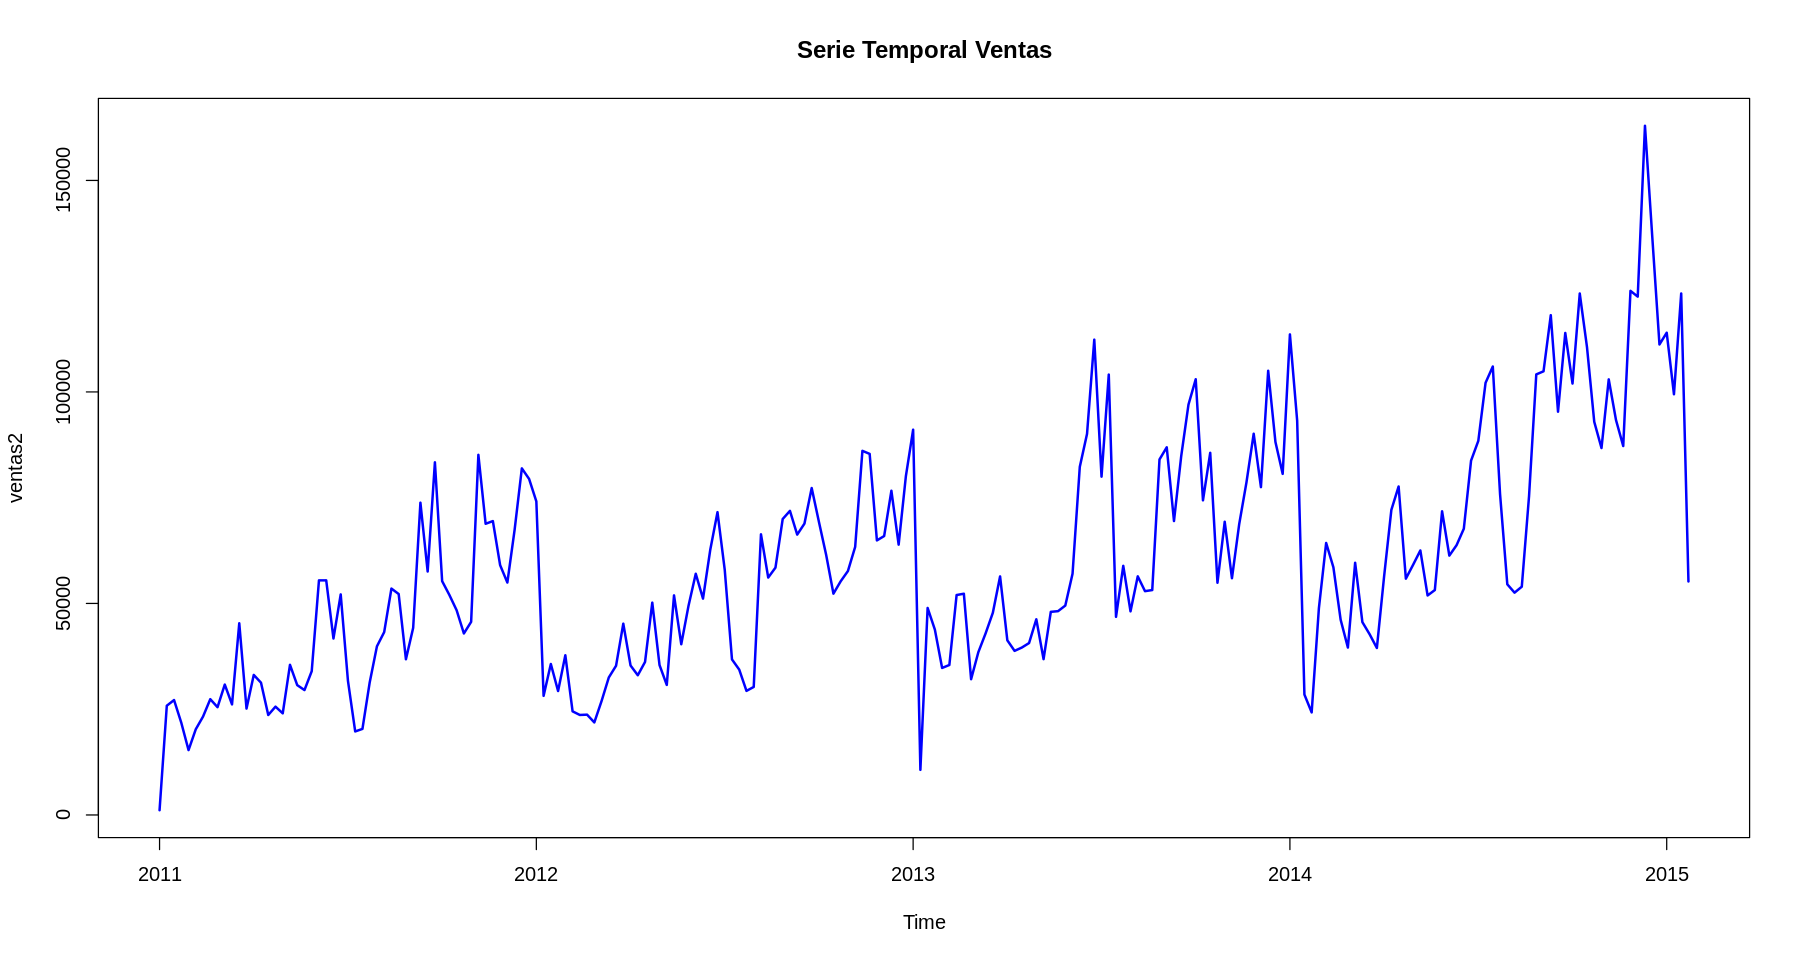

In [63]:
ventas2 <- ts(ventas1$Total_Sales, start = 2011, frequency = 52)
ts.plot(ventas2, col= 4,main="Serie Temporal Ventas",lwd=2)
options(repr.plot.width=14, repr.plot.height=6)

### Análisis estacional

La serie presenta una tendencia creciente sostenida a lo largo del tiempo. Anualmente las ventas aumentan hacia fin de año y luego bajan de manera abrupta en las primeras semanas del año siguiente. Esto se debe a un aumento sobre el final del año debido a las fiestas tradicionales.

A continuación ajustaremos un modelo lineal para intentar entender la incidencia de la varible "week" en el comportamiento de la variable "ventas". 

In [12]:
week = ventas1$semana/52
t = time(ventas2) - 2011
fit = lm(ventas2~t+week)
summary(fit)


Call:
lm(formula = ventas2 ~ t + week)

Residuals:
   Min     1Q Median     3Q    Max 
-71664  -8848  -1103   9279  61989 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    11321       2712   4.174  4.4e-05 ***
t              12776        990  12.904  < 2e-16 ***
week           44361       3959  11.205  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16460 on 209 degrees of freedom
Multiple R-squared:  0.6481,	Adjusted R-squared:  0.6448 
F-statistic: 192.5 on 2 and 209 DF,  p-value: < 2.2e-16


## Definimos: Coeficiente de Determinación

$$R^2 = \frac{SSR}{SST} =  \frac{SST-SSE}{SST}$$
Entonces $R^2$ es una medida de correlación de nuestras variables, o bien cuánto mejora el ajuste en términos relativos respecto a la media.

 * SST = Suma total de cuadrados
 * SSE = Suma total de cuadrados debido al error (variación sin explicar)
 * SSR = Suma total de cuadrados debido a la regresión (variación explicada)

Del análisis anterior surge que: El factor week es significativo y para poder plotear el ajuste, tenemos que convertir los valores a serie temporal. A su vez, para analizar los residuos debemos hacer lo mismo.

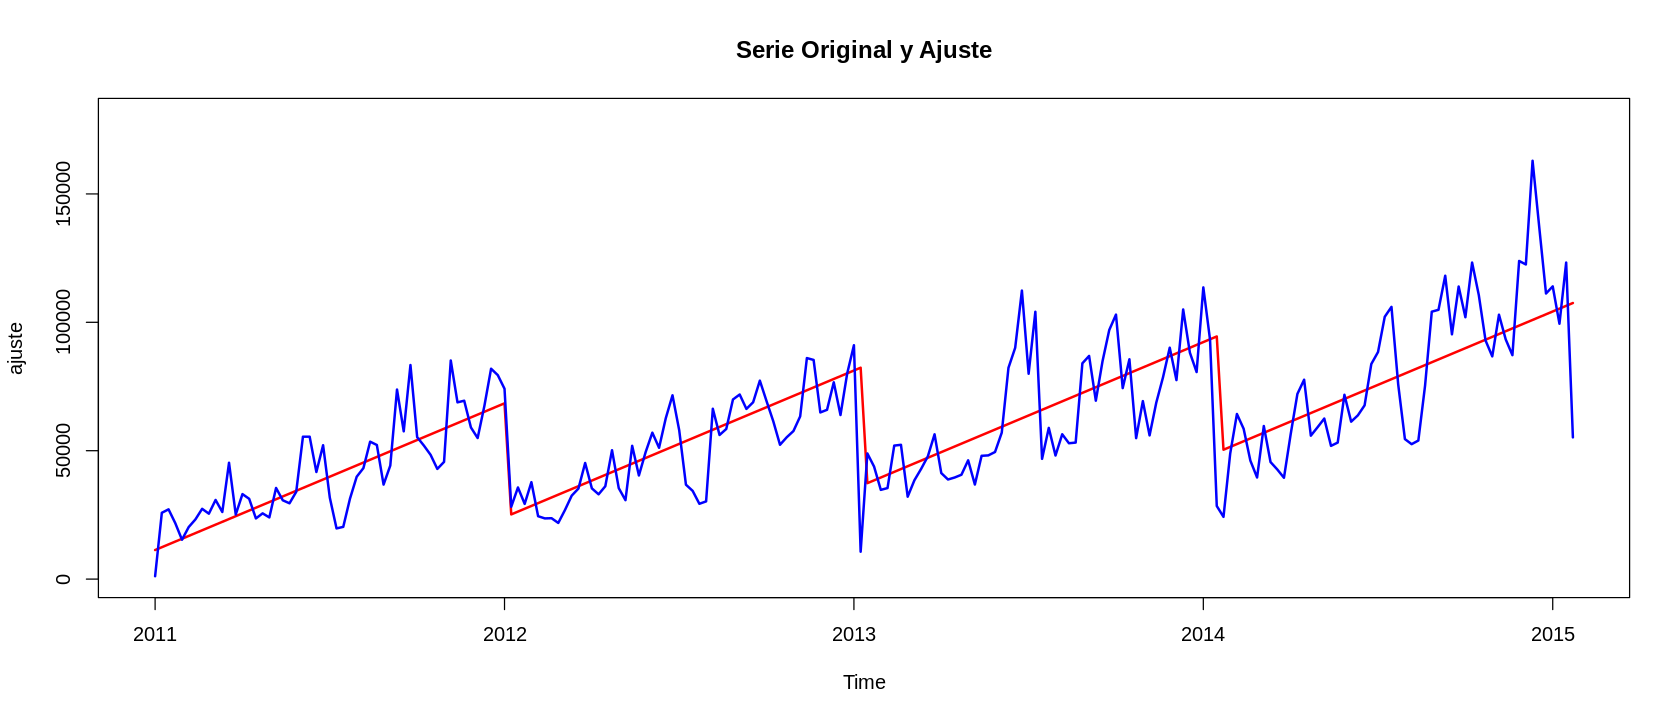

In [13]:
##genero una serie temporal sincronizada con la serie original y las predicciones del modelo lineal
ajuste= fitted(fit)
ajuste=ts(ajuste, start = 2011, freq = 52)
ts.plot(ajuste,ylim=c(0,180000), col= 2,lwd=2, main="Serie Original y Ajuste")
lines(ventas2,col= 4,lwd=2)

## Definimos: Error Cuadrático Medio de Predicción (RMSE)
 
Lo que hace aquí es realizar la mejor predicción posible usando el modelo ajustado de los valores de la serie y considerar la varianza del error cometido en la predicción. De nuevo, queremos el menor RMSE posible.

$$RMSE = \sqrt\frac{SSE~w}{W} = \sqrt{\frac{1}{W}\sum_{i=1}^{N} {w_i} {u^2_i}}  $$


In [14]:
RMSE = sigma(fit)
RMSE

[1] 16457.22

In [15]:
AIC = AIC(fit)
BIC = BIC(fit)
AIC
BIC

[1] 4723.021

[1] 4736.447

El modelo aproxima bastante bien la tendencia creciente anual y sostenida en el tiempo. También acompaña las caidas abruptas que se dan al principo de cada año. A continuación haremos el gráfico de los residuos (como serie temporal) para ver si obtenimos ruido blanco.

### Análisis de Fourier
Ahora utilizaremos Senos y cosenos para ajustar la tendencia anual. Una serie de Fourier es una serie infinita que converge puntualmente a una función periódica y continua a trozos (o por partes). Las series de Fourier constituyen la herramienta matemática básica del análisis de Fourier empleado para analizar funciones periódicas a través de la descomposición de dicha función en una suma infinita de funciones sinusoidales mucho más simples (como combinación de senos y cosenos con frecuencias enteras).

Con esta herramienta trataremos de aproximar una rampa periódica por cada vez más frecuencias. En el límite de infinitas frecuencias sería exactamente igual, pero en este caso el ajuste anterior (rampa) es mejor. Esto es culpa de la discontinuidad en las compras realizadas en las fiestas de fin de año. Son necesarias muchas funciones de seno y coseno para ajustar esa caida tan abrupta.

In [16]:
t = time(ventas2) - 2011
sint = sin(2*pi*t)
cost = cos(2*pi*t)
sint1= sin(2*pi*2*t)
cost1= cos(2*pi*2*t)
sint2= sin(2*pi*3*t)
cost2= cos(2*pi*3*t)

In [17]:
fit5 = lm(ventas2~t+sint+cost+sint1+cost1+sint2+cost2)
summary(fit5)


Call:
lm(formula = ventas2 ~ t + sint + cost + sint1 + cost1 + sint2 + 
    cost2)

Residuals:
   Min     1Q Median     3Q    Max 
-51508 -10711   -937  10397  61503 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  32706.3     2352.2  13.905  < 2e-16 ***
t            13269.4     1008.1  13.163  < 2e-16 ***
sint        -15882.3     1683.7  -9.433  < 2e-16 ***
cost          2284.5     1631.0   1.401    0.163    
sint1        -7379.1     1657.1  -4.453 1.39e-05 ***
cost1         2509.8     1634.4   1.536    0.126    
sint2         -974.9     1648.6  -0.591    0.555    
cost2         2136.4     1638.6   1.304    0.194    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16900 on 204 degrees of freedom
Multiple R-squared:  0.6378,	Adjusted R-squared:  0.6254 
F-statistic: 51.33 on 7 and 204 DF,  p-value: < 2.2e-16


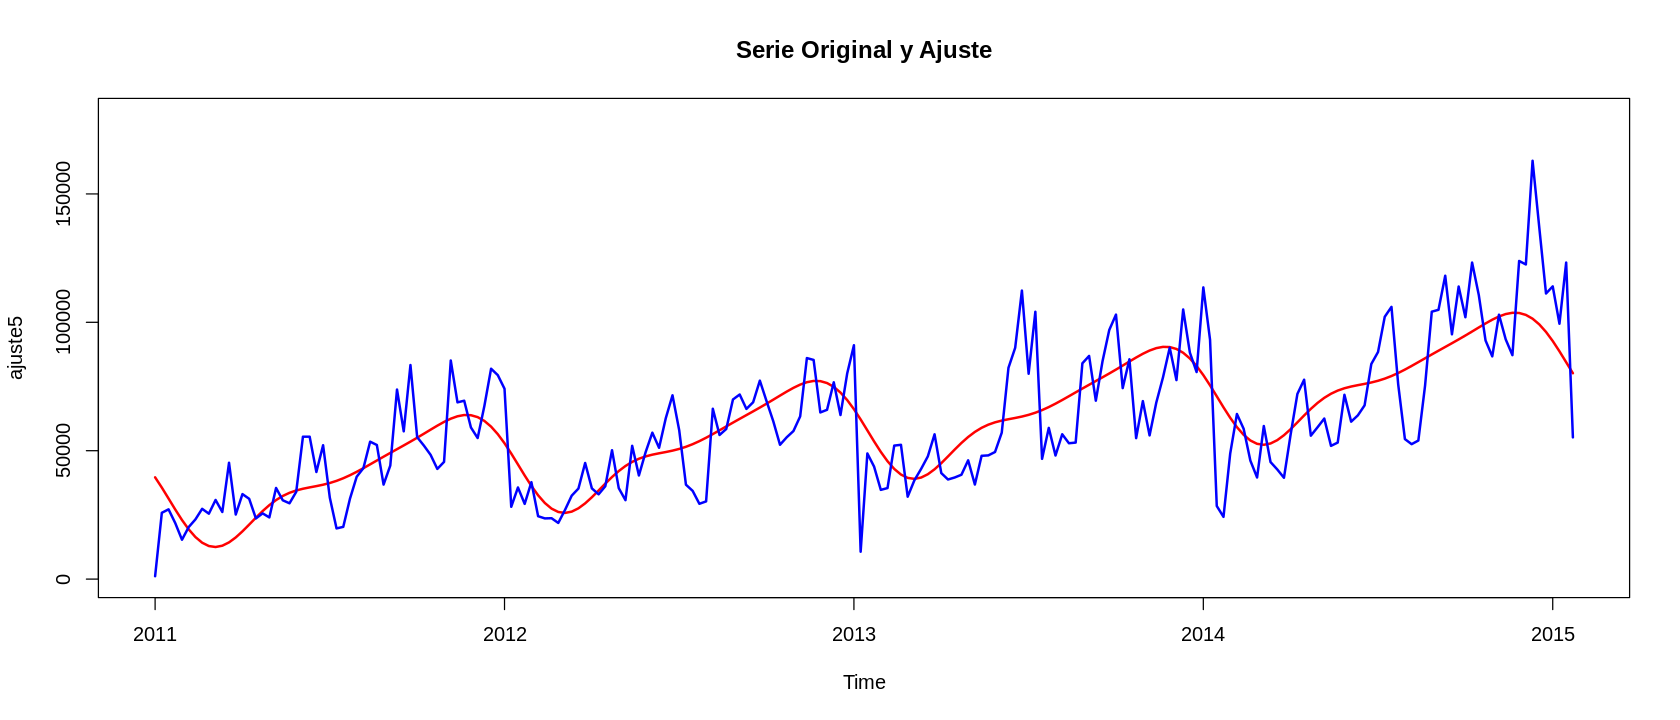

In [18]:
ajuste5= fitted(fit5)
ajuste5=ts(ajuste5, start = 2011, freq = 52)
ts.plot(ajuste5,ylim=c(0,180000), col= 2,lwd=2, main="Serie Original y Ajuste")
lines(ventas2,col= 4,lwd=2)

In [19]:
RMSEF = sd(residuals(fit5))
RMSEF
RMSE

[1] 16616.9

[1] 16457.22

In [20]:
AICF = AIC(fit5)
BICF = BIC(fit5)

AICF
AIC
BICF
BIC

[1] 4739.134

[1] 4723.021

[1] 4769.343

[1] 4736.447

Vemos que el ajuste utilizando el factor week es mejor que el análsis de Fourier por lo tanto vamos a realizar el estudio de los residuos del primer modelo.

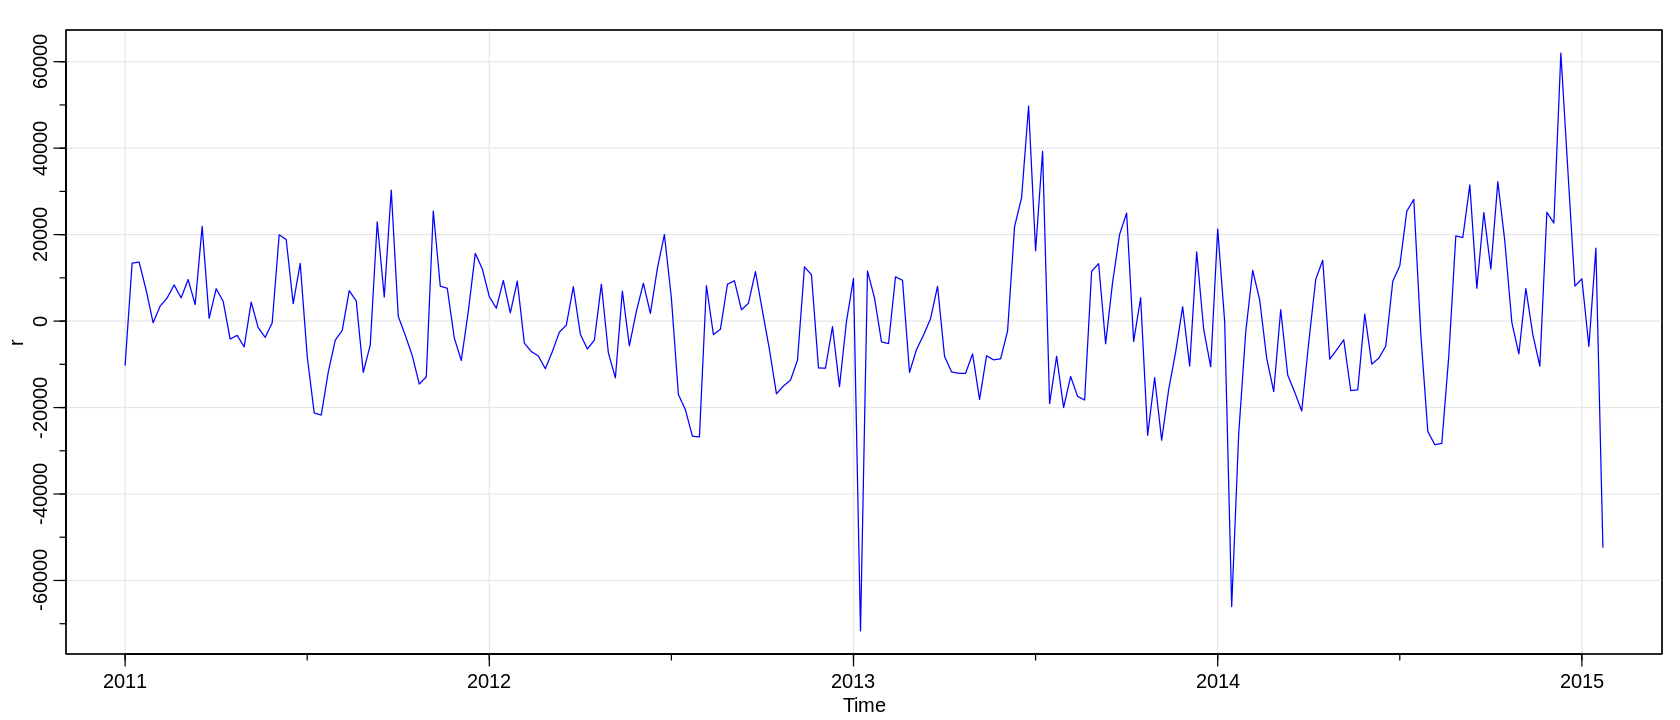

In [21]:
#Generamos una serie temporal con los valores de los residuos y los ploteamos
r=ts(residuals(fit),start=2011,freq=52)
tsplot(r, lwd=1, col=4)

Observamos que la gráfica no se asemeja a la de ruido blanco.

## Periodograma

El *periodograma* es una forma sistemática de recorrer las correlaciones anteriores y calcular cuáles son significativas.

Haremos un primer análisis para ver el periodograma de la serie "ventas2" y luego haremos lo mismo para los residuos obtenidos en el primer modelo, intentando en esta última situación conseguir mayor información para continuar nuestro análisis.

A su vez, debido a la *FFT: Fast Fourier Transform* muchos de los cálculos usados en una regresión pueden ser reusados para calcular otras, llevando a un algoritmo eficiente.

In [22]:
n=length(t) 
n

[1] 212

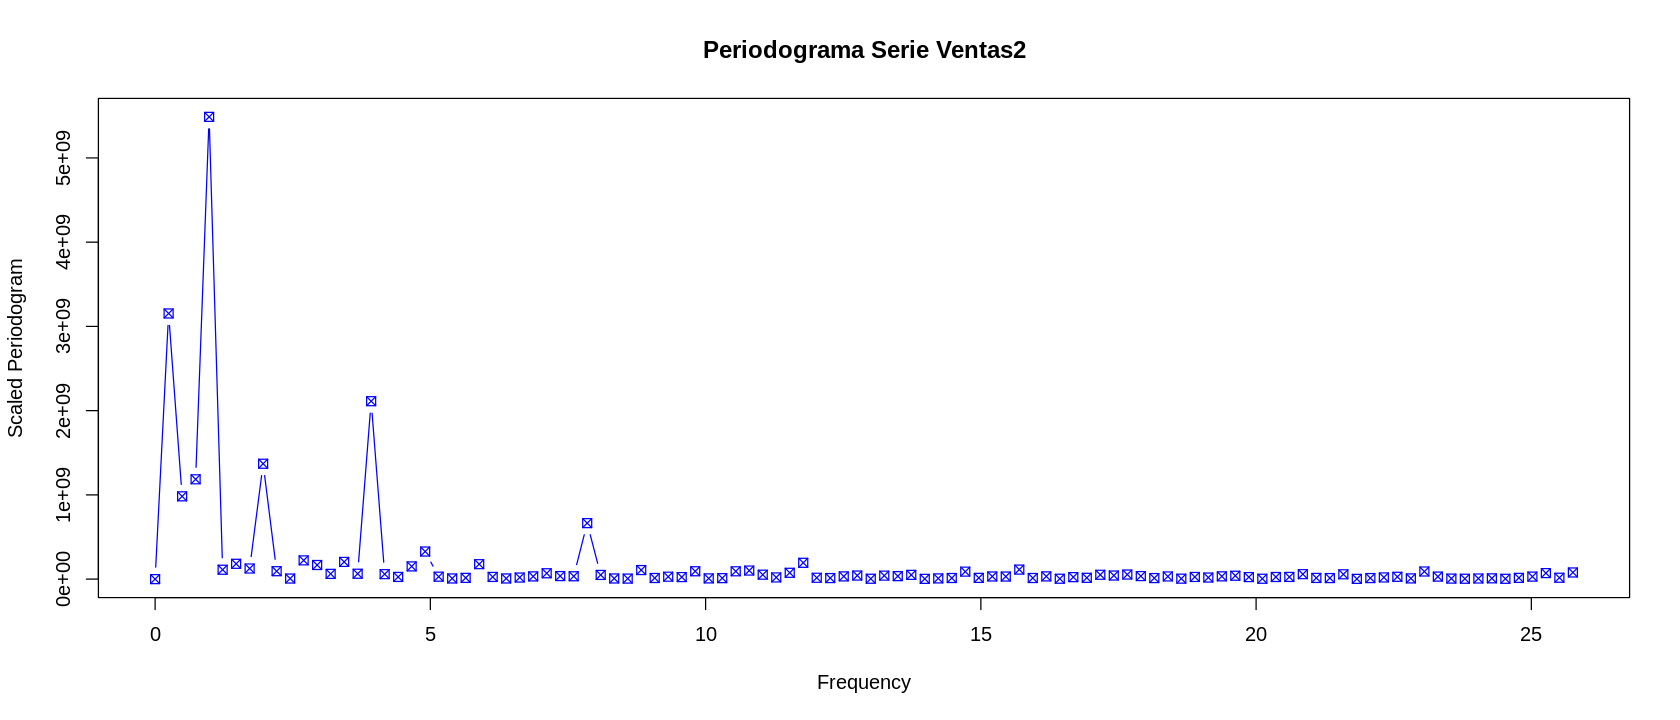

In [23]:
options(repr.plot.width=14, repr.plot.height=6)

I = abs(fft(ventas2-mean(ventas2)))^2/n
P = (52/n)*I[1:(n/2)] 
f = (0:(n/2-1))/n*52 

plot(f, P, type="b", xlab="Frequency", ylab="Scaled Periodogram", main="Periodograma Serie Ventas2", col=4, lwd=1, pch=7)

Vemos que las primeras semanas son las más significaticas y que se repite su comportamiento año a año, en donde vemos una caída importante de las ventas, una correlación inversa. Ese comportamiento es validado al hacer el estudio del periodograma con los residuos.

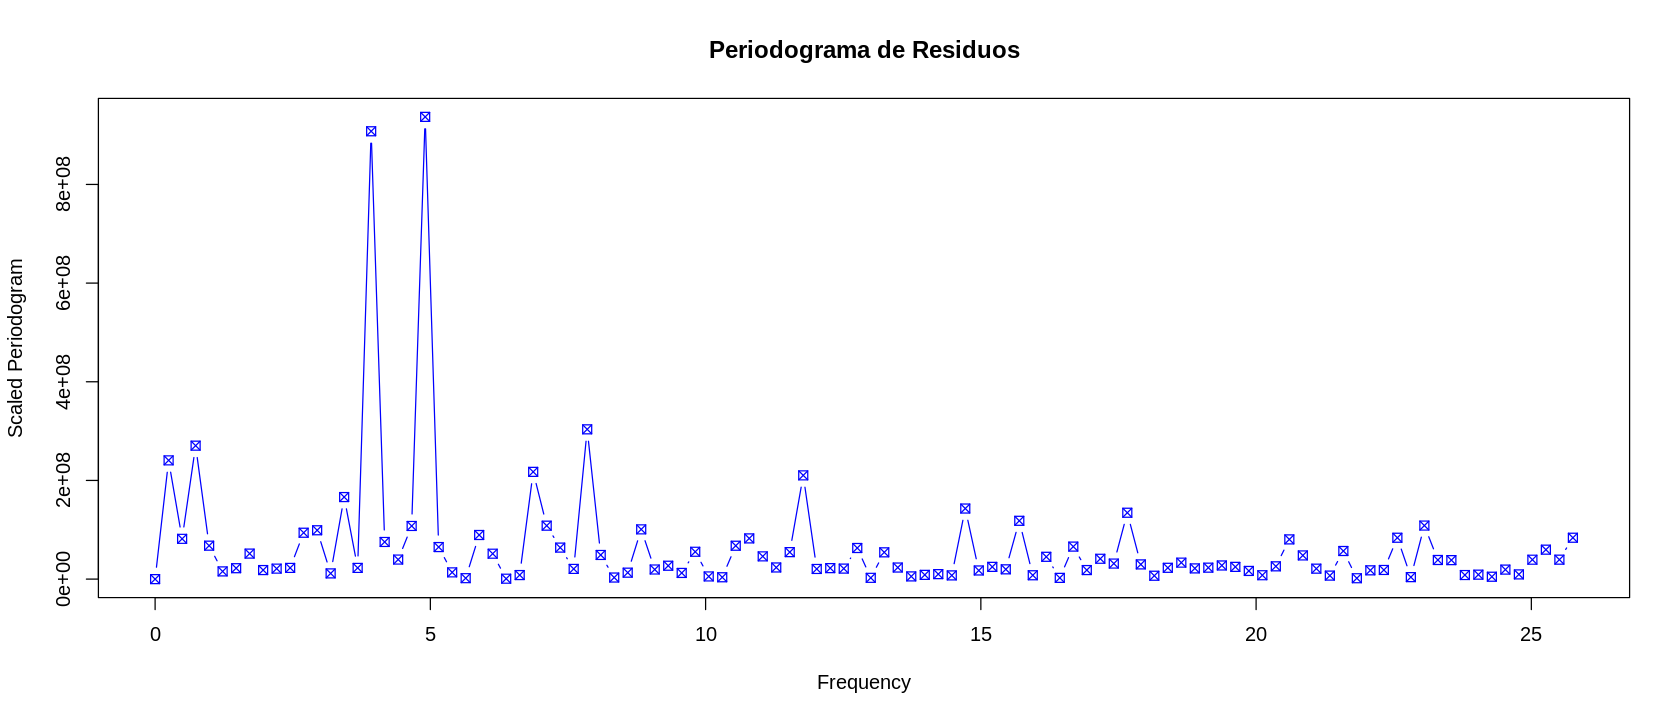

In [24]:
options(repr.plot.width=14, repr.plot.height=6)

I = abs(fft(r))^2/n
P = (52/n)*I[1:(n/2)] 
f = (0:(n/2-1))/n*52 

plot(f, P, type="b", xlab="Frequency", ylab="Scaled Periodogram", main="Periodograma de Residuos", col=4, lwd=1, pch=7)

Para finalizar el análisis del modelo haremos el cálculo de autocorrelación y la autocorrelación parcial.

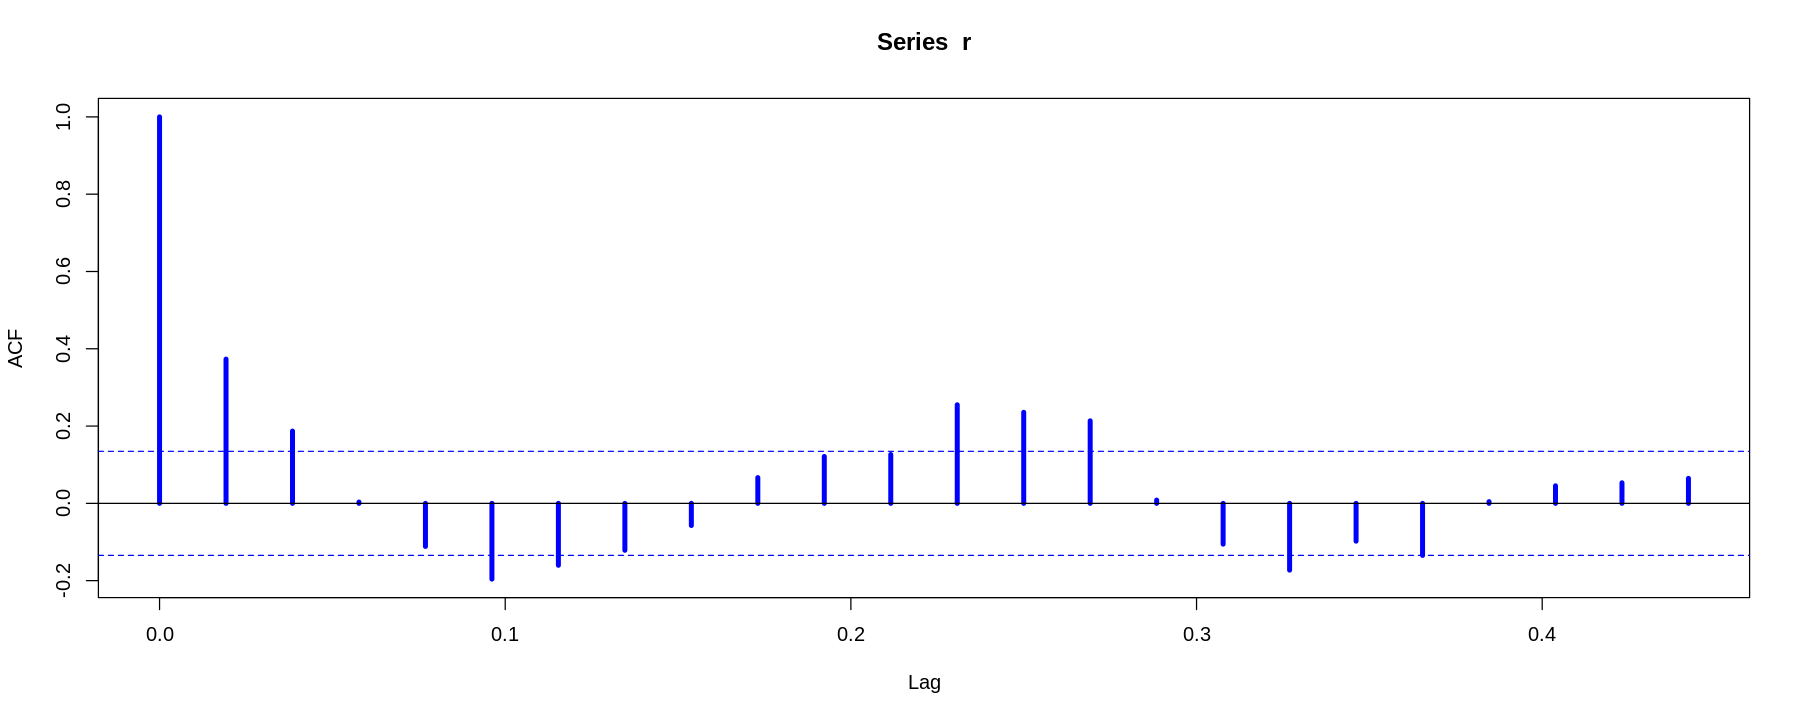

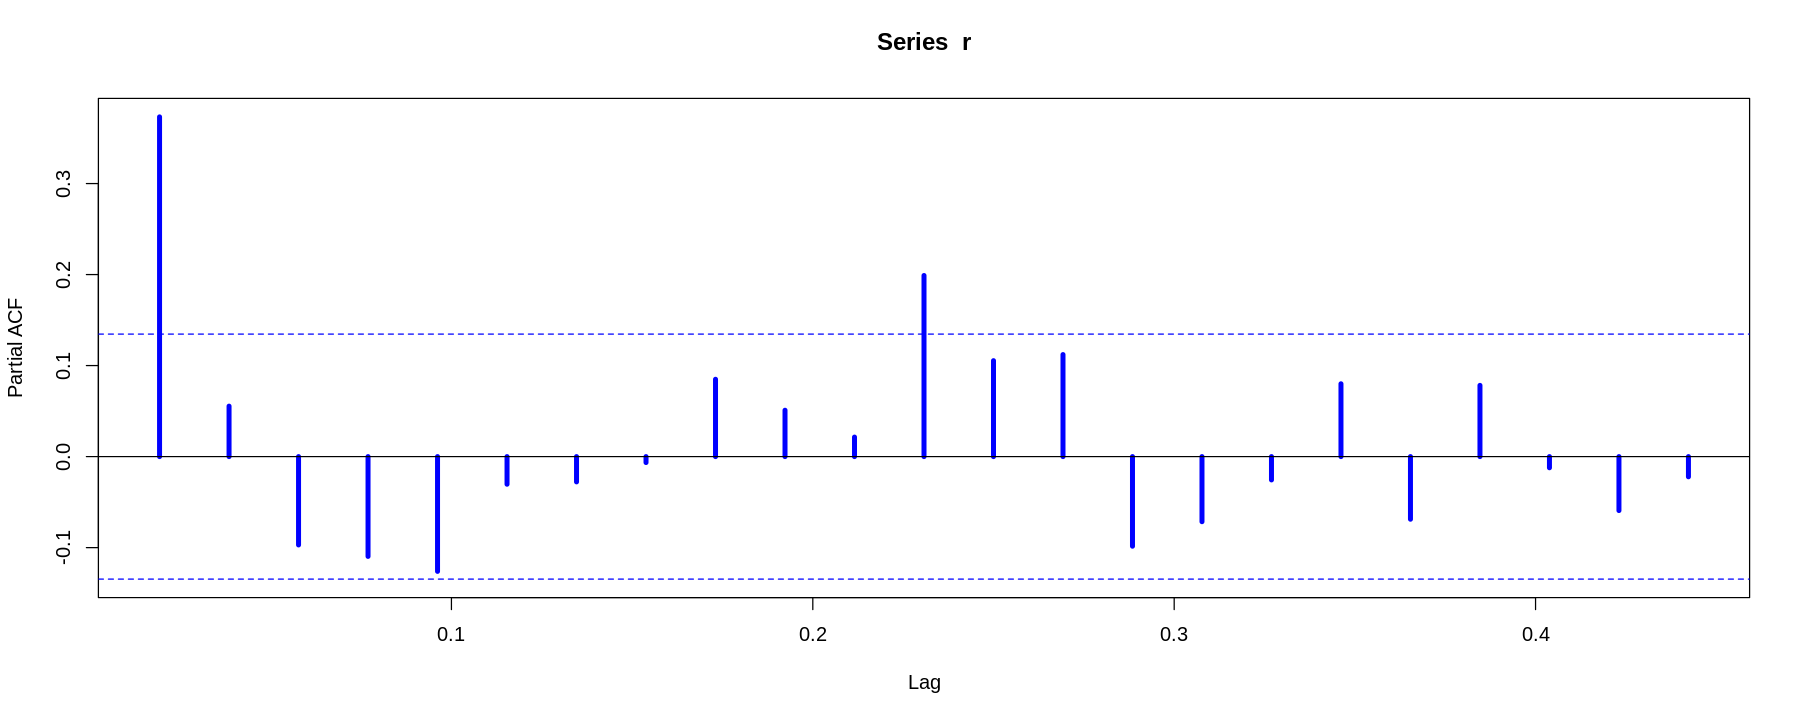

In [25]:
options(repr.plot.width=15, repr.plot.height=6)
acf(r, lwd=4, col=4)
pacf(r, lwd=4, col=4)

## Analicemos la ACF y PACF

Al realizar la ACF vemos que hay una pequeña correlación negativa aproximadamente cada 0,2. La PACF corta luego del 12 así que podemos probar con un modelo  𝐴𝑅(12) . Aquí conviene por simplicidad el comando Arima de la biblioteca forecast. Puede usarse también arima, que es el básico de R.

## Ajustamos un modelo AR(12) al residuo.

In [26]:
fit1 = Arima(r,order=c(12,0,0),include.mean = FALSE)
summary(fit1)

Series: r 
ARIMA(12,0,0) with zero mean 

Coefficients:
         ar1     ar2      ar3      ar4      ar5      ar6      ar7      ar8
      0.3269  0.0730  -0.0622  -0.0496  -0.0850  -0.0180  -0.0213  -0.0311
s.e.  0.0691  0.0744   0.0746   0.0744   0.0744   0.0739   0.0764   0.0756
         ar9   ar10     ar11    ar12
      0.0757  0.043  -0.0446  0.2226
s.e.  0.0758  0.076   0.0758  0.0721

sigma^2 estimated as 217373132:  log likelihood=-2330.1
AIC=4686.2   AICc=4688.04   BIC=4729.84

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE      MASE        ACF1
Training set 68.84815 14320.23 10214.18 21.06129 215.4928 0.7165657 -0.02115123


In [27]:
RMSE1 = sd(residuals(fit1))
RMSE1

[1] 14353.96

In [28]:
AIC1 = AIC(fit1)
BIC1 = BIC(fit1)

AIC1
BIC1

[1] 4686.202

[1] 4729.838

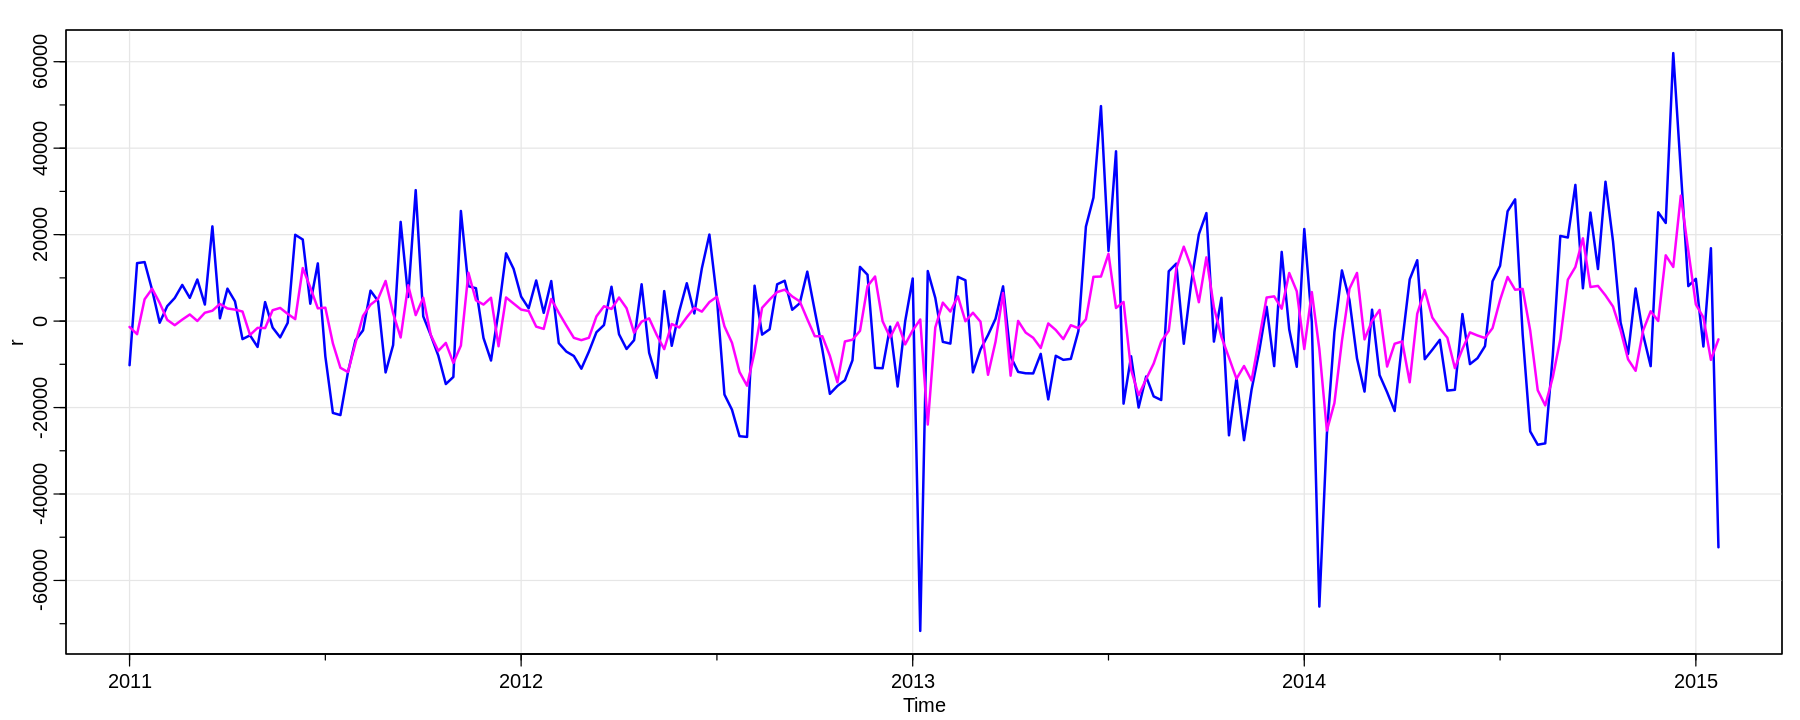

In [29]:
tsplot(r, col=4, lwd=2)

#Notar que el ajuste de Arima preserva la time series, por lo que no tengo que reconstruir los tiempos.
ajuste1 = fitted(fit1)
lines(ajuste1,col=6, lwd=2)

Cálculamos el desvío estandar de los residuos para ver que coincide con el RMSE. La diferencia radica en cómo considera los grados de libertad en el denominador. Esta diferencia es mínima para un número grande de datos.

In [30]:
sd(r-ajuste1)

[1] 14353.96

Revisemos el resultado del fit1 del modelo Arima, y decidimos ajutar un modelo de regresión lineal con el coeficiente ar12 que es significativo.

In [31]:
summary(fit1)

Series: r 
ARIMA(12,0,0) with zero mean 

Coefficients:
         ar1     ar2      ar3      ar4      ar5      ar6      ar7      ar8
      0.3269  0.0730  -0.0622  -0.0496  -0.0850  -0.0180  -0.0213  -0.0311
s.e.  0.0691  0.0744   0.0746   0.0744   0.0744   0.0739   0.0764   0.0756
         ar9   ar10     ar11    ar12
      0.0757  0.043  -0.0446  0.2226
s.e.  0.0758  0.076   0.0758  0.0721

sigma^2 estimated as 217373132:  log likelihood=-2330.1
AIC=4686.2   AICc=4688.04   BIC=4729.84

Training set error measures:
                   ME     RMSE      MAE      MPE     MAPE      MASE        ACF1
Training set 68.84815 14320.23 10214.18 21.06129 215.4928 0.7165657 -0.02115123


Los coeficientes significativos son el primero y el de lag 12 (`ar12`), ya que están a más de dos standard error (s.e.) de $0$. Podemos intentar ajustar un modelo de la forma:

$$r_t = \phi r_{t-12}$$

y olvidarnos del resto. Sin embargo, en `Arima` no podemos forzar los coeficientes a $0$. Hay que hacerlo a mano, por ejemplo mediante mínimos cuadrados con la serie laggeada.

In [32]:
dos_series = ts.intersect(r ,r_12 = lag(r,-12))

fit2 = lm(r ~ 0 + r_12 , data = dos_series)
summary(fit2)


Call:
lm(formula = r ~ 0 + r_12, data = dos_series)

Residuals:
   Min     1Q Median     3Q    Max 
-66494  -9593  -1349   8343  59660 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
r_12  0.30712    0.07378   4.163 4.68e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16000 on 199 degrees of freedom
Multiple R-squared:  0.0801,	Adjusted R-squared:  0.07547 
F-statistic: 17.33 on 1 and 199 DF,  p-value: 4.683e-05


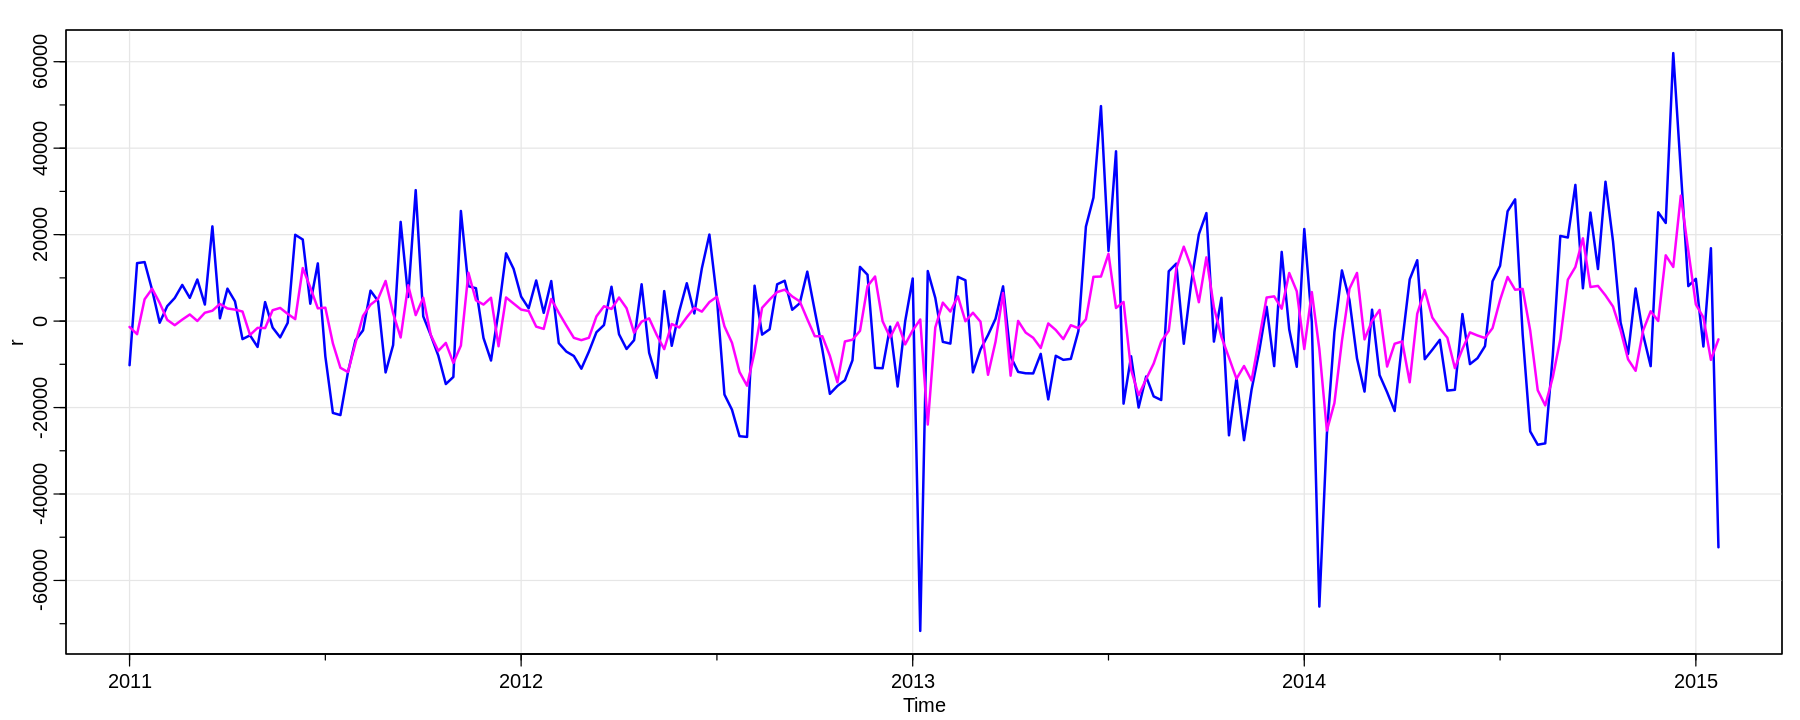

In [33]:
tsplot(r, col=4, lwd=2)

ajuste2 = fitted(fit2)
ajuste2 = ts(ajuste2,start=2011,freq=52)
lines(ajuste1,col=6, lwd=2)

In [34]:
RMSE2 = sd(residuals(fit2))

RMSE2

[1] 15995.11

Vemos que este modelo no es mejor que Arima porque tenemos un resultado de RMSE mayor. Por lo tanto nos quedamos con el modelo anterior.

### SARIMA

Intentaremos probar un ajuste con el modelo SARIMA. Esta otra extensión de los modelos ARIMA se refiere a la ESTACIONALIDAD. Un modelo ARIMA estacional se forma al incluir términos estacionales adicionales en el modelo ARIMA. Está escrito de la siguiente manera:

$$ARIMA(p,d,q)(P,D,Q)_{s}$$

* $p, d, q$ se refieren a la parte no estacional del modelo
* $P, D, Q$ se refieren a la parte estacional del modelo.
* $s$ es el número de observaciones por año. 

Por ejemplo, un modelo ARIMA (1,1,1) (1,1,1) ₄ es para datos trimestrales.

In [35]:
fit3= Arima(r, order = c(1, 0, 0), seasonal = list ( order = c(1, 0, 0) ,period = 12),  include.mean=FALSE)
summary(fit3)

Series: r 
ARIMA(1,0,0)(1,0,0)[12] with zero mean 

Coefficients:
         ar1    sar1
      0.3485  0.2100
s.e.  0.0679  0.0742

sigma^2 estimated as 221151190:  log likelihood=-2336.87
AIC=4679.73   AICc=4679.85   BIC=4689.8

Training set error measures:
                    ME     RMSE      MAE      MPE     MAPE      MASE
Training set -7.293951 14800.84 10447.98 17.89519 209.2579 0.7329679
                     ACF1
Training set -0.001947362


In [36]:
RMSE3 = sd(residuals(fit3))
RMSE1
RMSE3

[1] 14353.96

[1] 14835.87

Comparamos los residuos de los ajustes realizados.

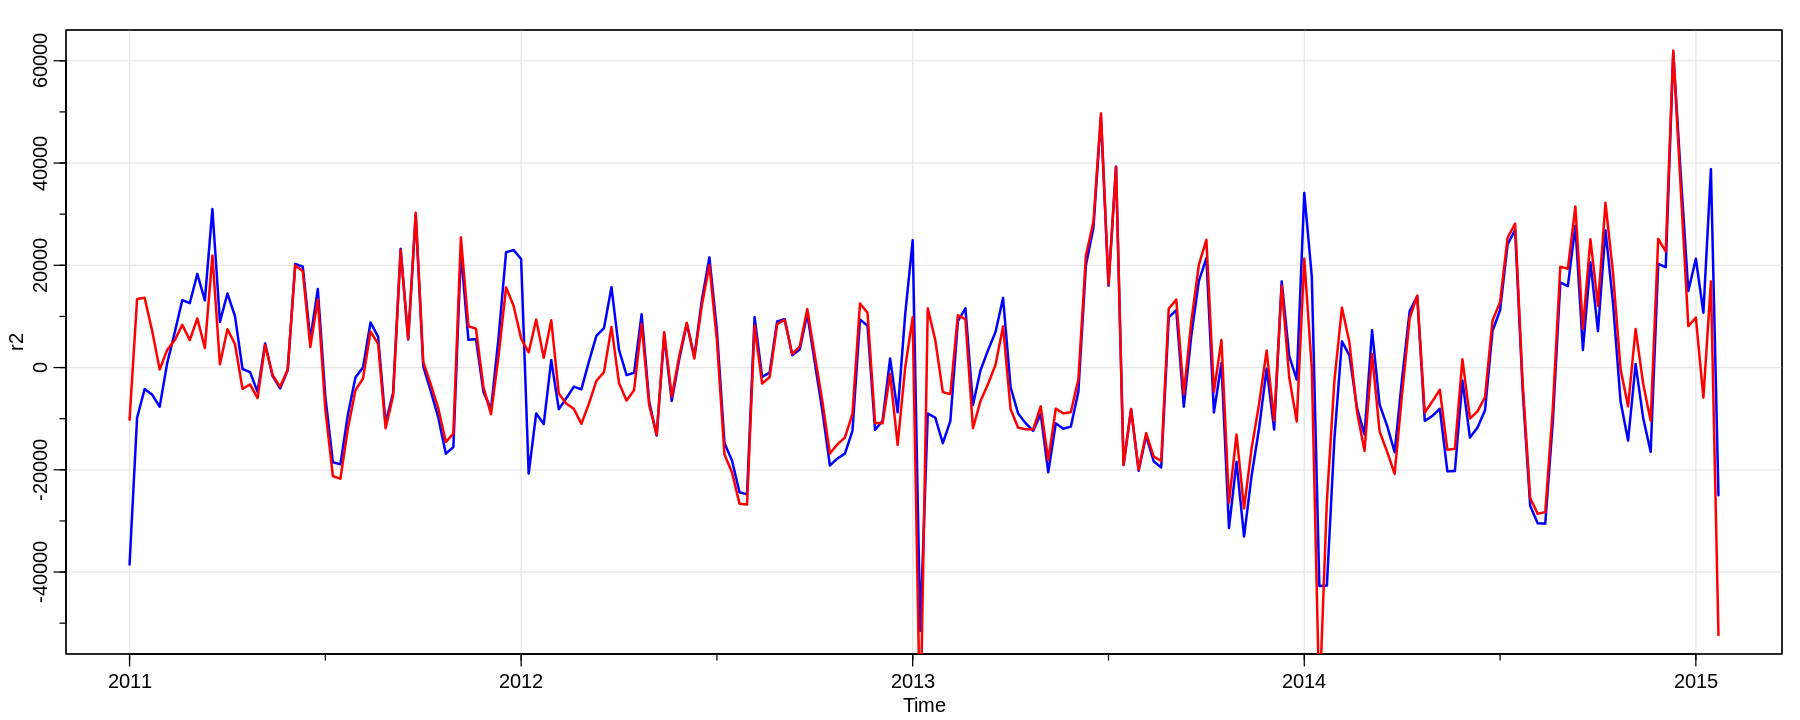

In [37]:
r2=ts(residuals(fit5),start=2011,freq=52)
tsplot(r2, lwd=2, col=4)
lines(r,col= 2,lwd=2)

## Resumen

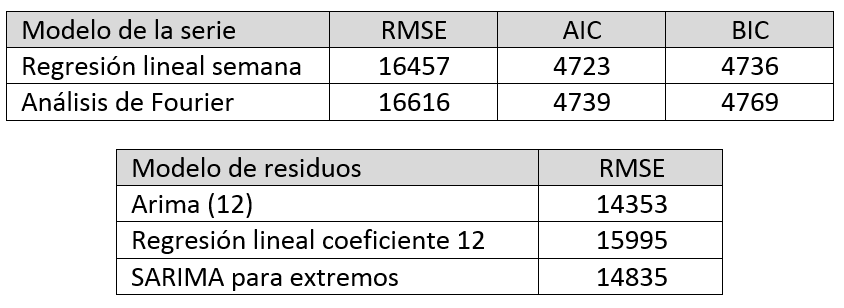

## Conclusión

Luego de analizar varios modelos y utilizar las técnicas vistas en clase, concluímos que el modelo que mejor ajusta a los residuos es SARIMA 12. Entendemos que tiene un valor un poco mayor de RMSE con relación al ARIMA de orden 12 pero solo utiliza dos coefientes.

### Predicción de seis meses para adelante (en semanas)

Para continuar el análisis vamos a realizar una serie de predicciones de los valores de las ventas a futuro usando la función "predict". Estos puntos de tiempo tienen que ser la *continuación* de las series $t$ y $week$ en este caso. 

In [38]:
## Construimos los nuevos datos a evaluar el modelo de regresión lineal

#Agregamos tiempos para 24 semanas en el futuro. para el calculo de by tomamos 1/52
new_t = seq(2015,2015.4615,by=0.01923) - 2011
#Lo convierto en serie temporal
new_t = ts(new_t,start=2015,freq=52)
#Le agrego los factores
new_week = new_t - 4

#Predigo sobre los nuevos datos.
new_data = data.frame(t=new_t,week=new_week)
prediccion= predict(fit, new_data);

#Convierto el resultado en time series
prediccion = ts(prediccion,start=2015,freq=52)
prediccion

A Time Series:
       1        2        3        4        5        6        7        8 
62423.09 63521.83 64620.57 65719.32 66818.06 67916.80 69015.54 70114.29 
       9       10       11       12       13       14       15       16 
71213.03 72311.77 73410.51 74509.26 75608.00 76706.74 77805.49 78904.23 
      17       18       19       20       21       22       23       24 
80002.97 81101.71 82200.46 83299.20 84397.94 85496.68 86595.43 87694.17

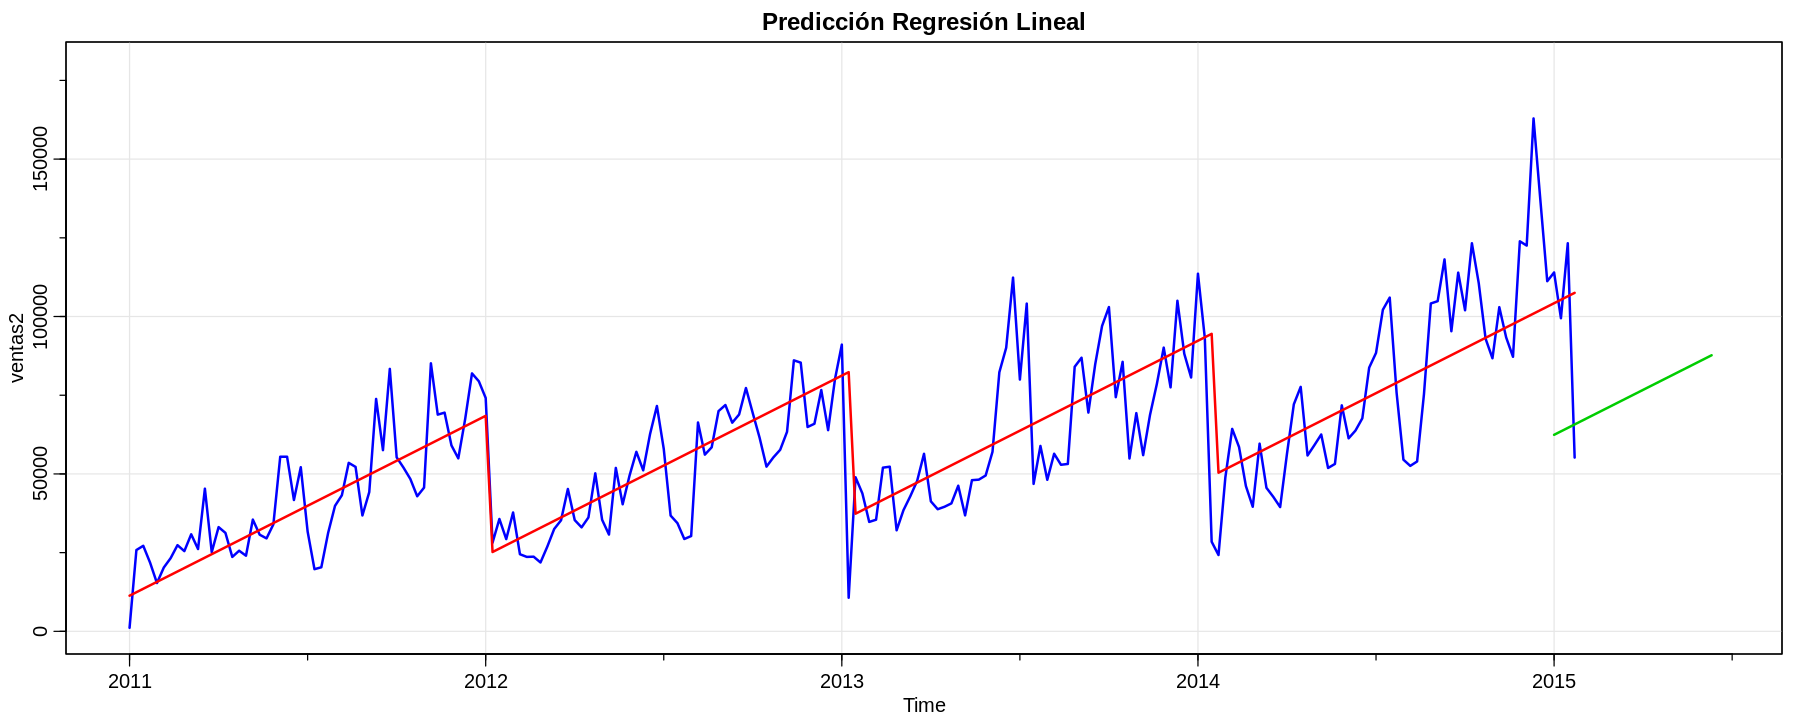

In [39]:
tsplot(ventas2,xlim=c(2011,2015.4615),ylim=c(0,180000), lwd=2, col=4, main="Predicción Regresión Lineal")
lines(ajuste,lwd=2, col=2)
lines(prediccion,lwd=2, col=3)

Ahora haremos la predicción de 6 meses para adelante del modelo ARIMA que ajustamos sobre los residuos, utilizando la función "forecast".

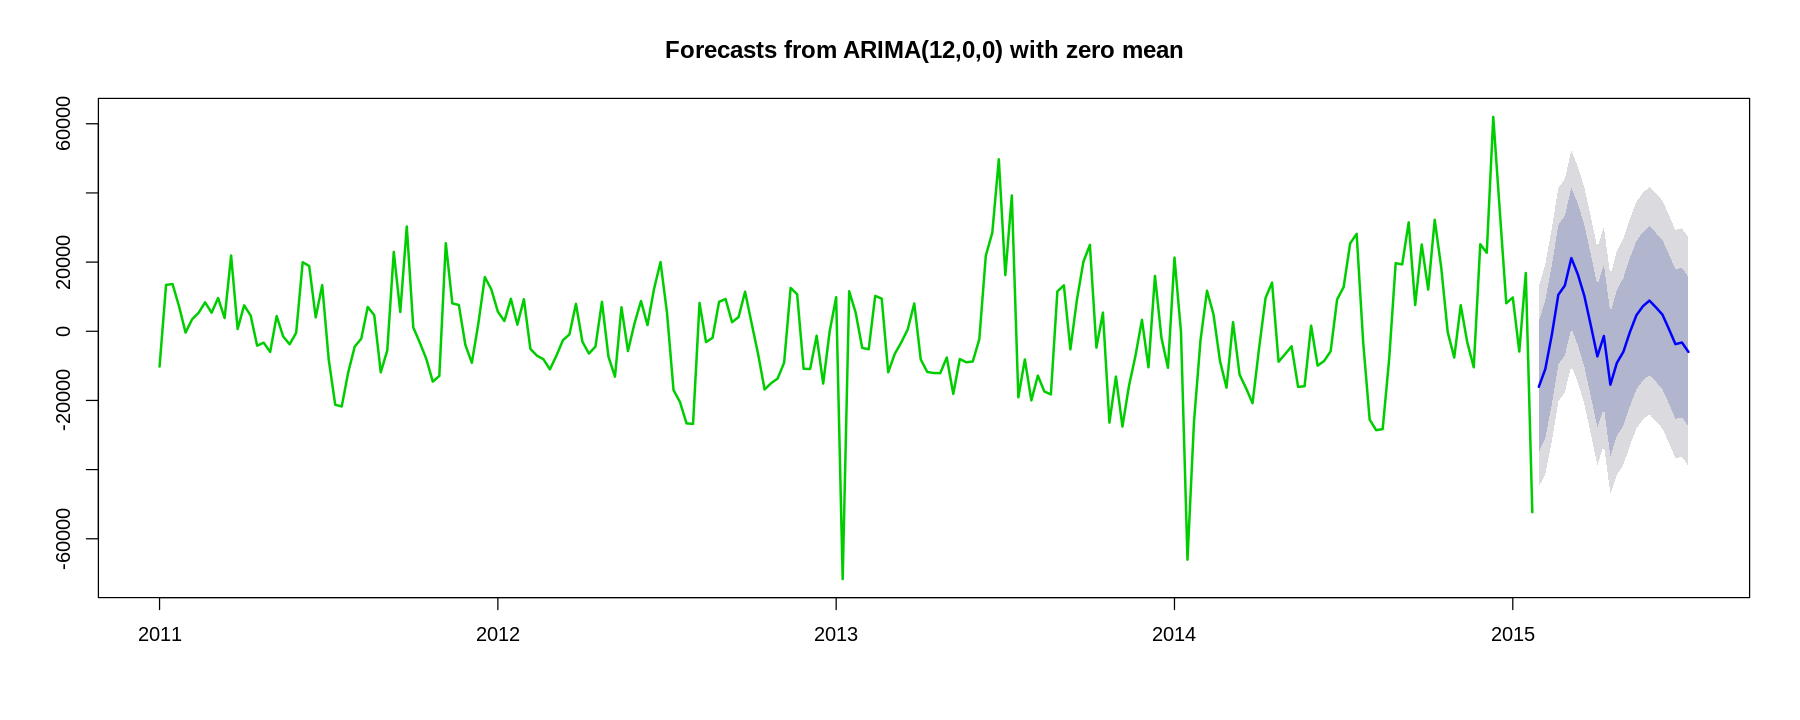

In [40]:
prediccion1 = forecast(fit1,h=24)

plot(prediccion1,col=3, lwd=2)

Podemos extraer la media de la predicción y los extremos del intervalo de confianza al 95%.
La columna de lower tiene el valor del IdC al 95% por abajo y la columna de upper tiene el valor del IdC al 95% por arriba.

In [41]:
prediccion1_media = prediccion1$mean
prediccion1_lower = prediccion1$lower[,2]   
prediccion1_upper = prediccion1$upper[,2]

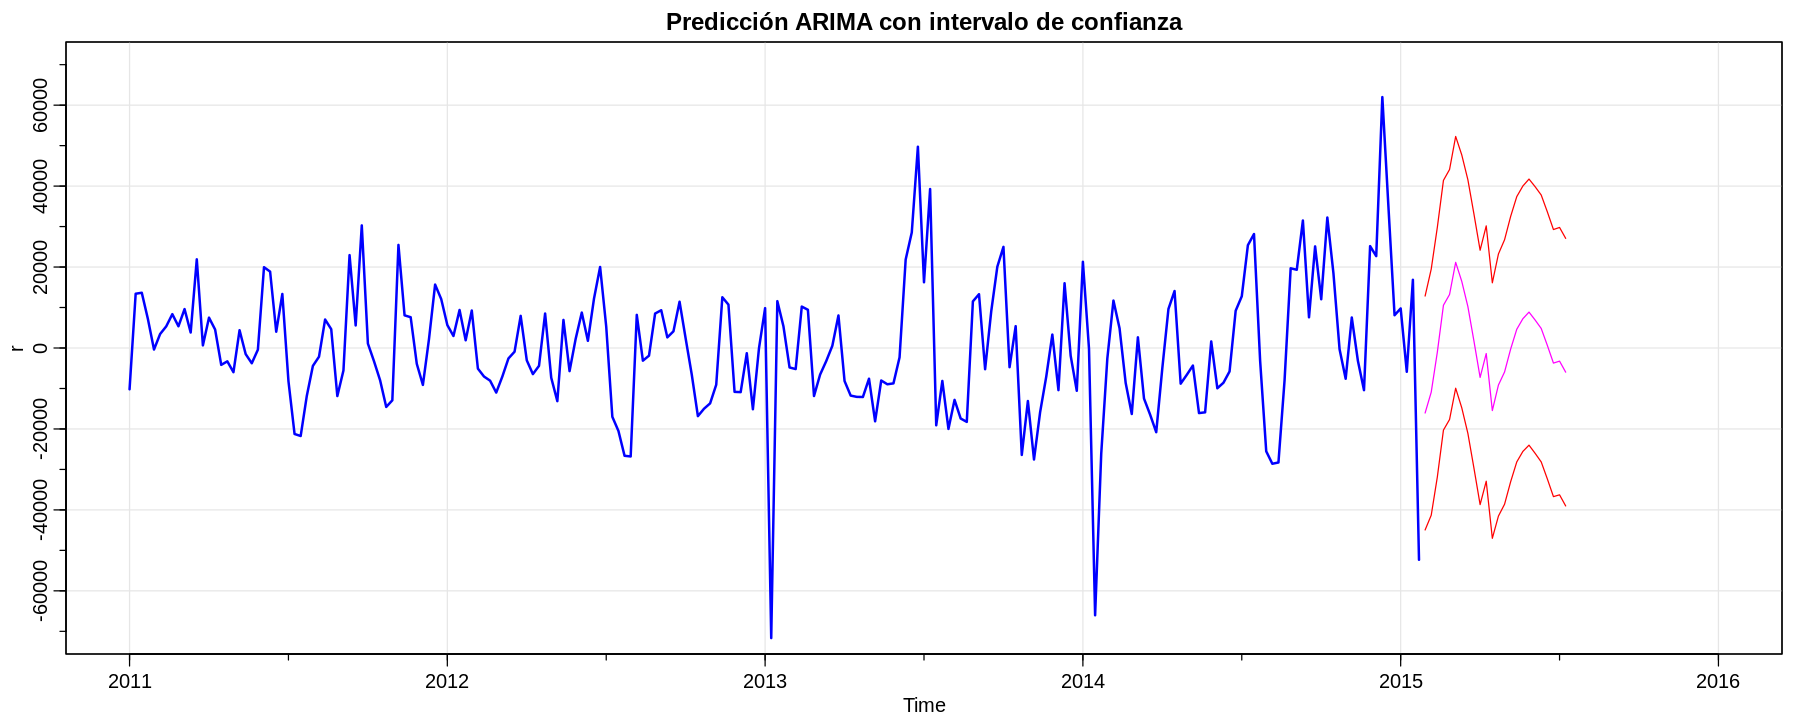

In [42]:
tsplot(r,xlim=c(2011,2016),ylim=c(-70000,70000), lwd=2, col=4, main="Predicción ARIMA con intervalo de confianza")
lines(prediccion1_media,col=6)
lines(prediccion1_lower,col=2)
lines(prediccion1_upper,col=2)

#### Nota sobre los intervalos de confianza:

Formalmente, el intervalo anterior asume que la varianza solo es producto de la parte AR ajustada a los residuos. En realidad también se agrega incertidumbre debido al modelo lineal ajustado para tendencia y estacionalidad. Sin embargo, no es fácil combinar ambas cosas. De todos modos en general constituye una buena estimación.

Ahora haremos la predición de 6 meses para adelante del modelo SARIMA que ajustamos sobre los residuos, utilzando la funcion "forecast".

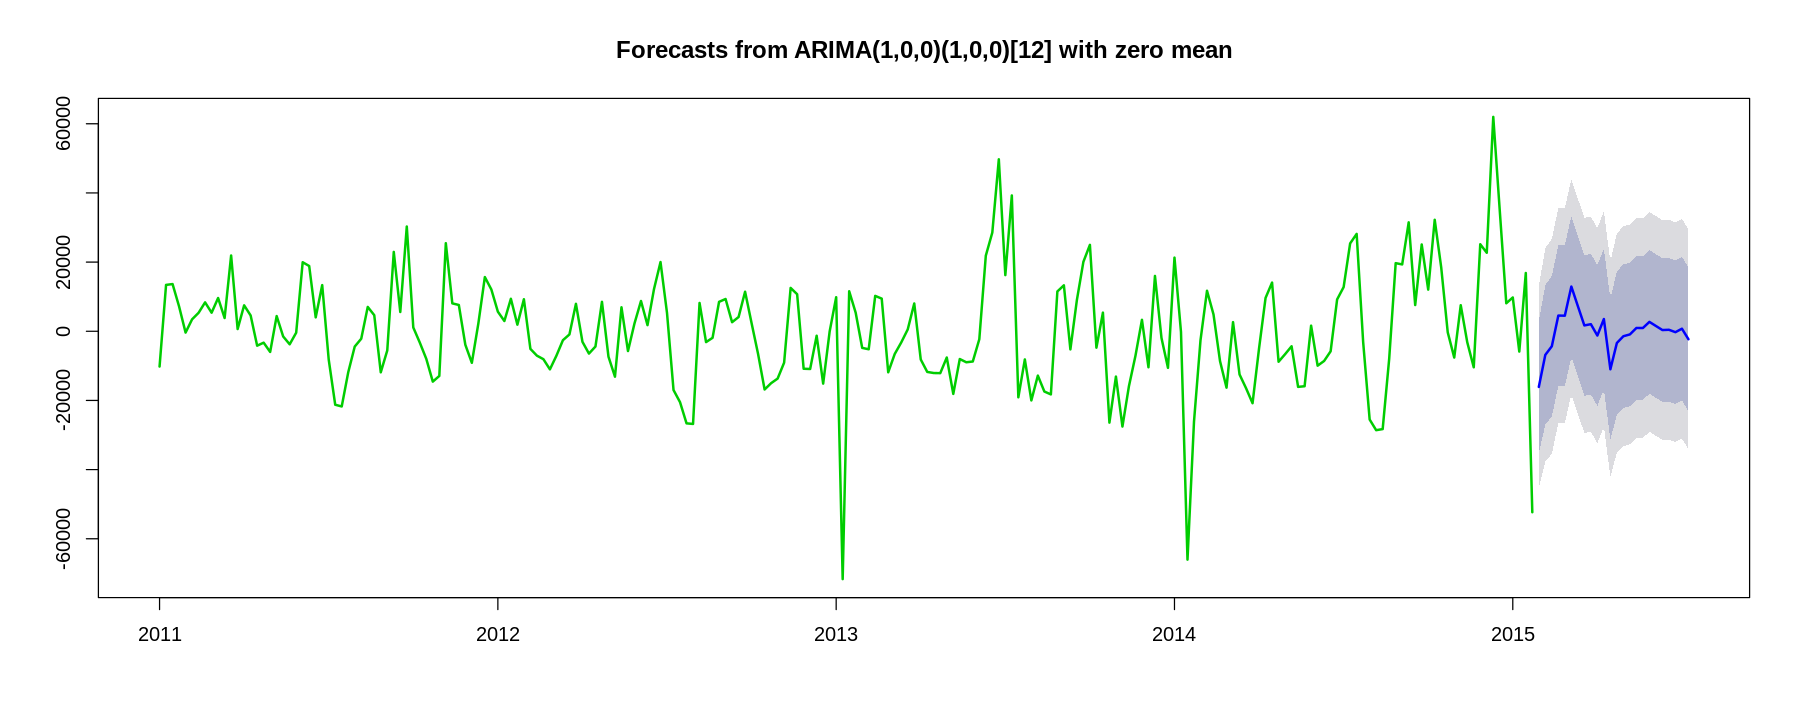

In [43]:
#predicción de SARIMA
prediccion2 = forecast(fit3,h=24)
plot(prediccion2,col=3, lwd=2)

In [44]:
prediccion2_media = prediccion2$mean
prediccion2_lower = prediccion2$lower[,2]   
prediccion2_upper = prediccion2$upper[,2]

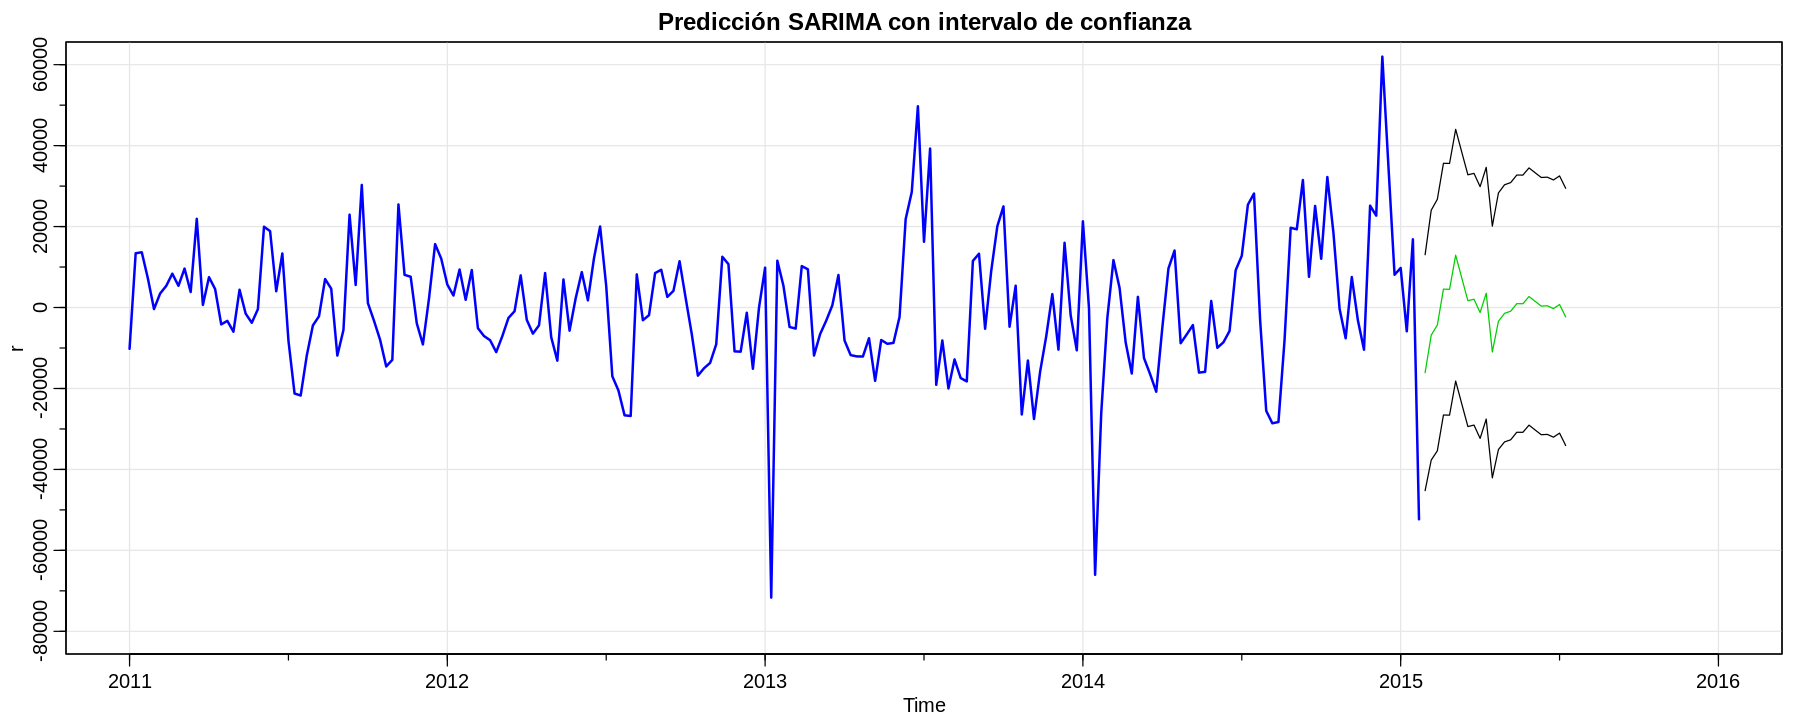

In [45]:
tsplot(r,xlim=c(2011,2016),ylim=c(-80000,60000), lwd=2, col=4,main="Predicción SARIMA con intervalo de confianza")
lines(prediccion2_media,col=3)
lines(prediccion2_lower,col=1)
lines(prediccion2_upper,col=1)

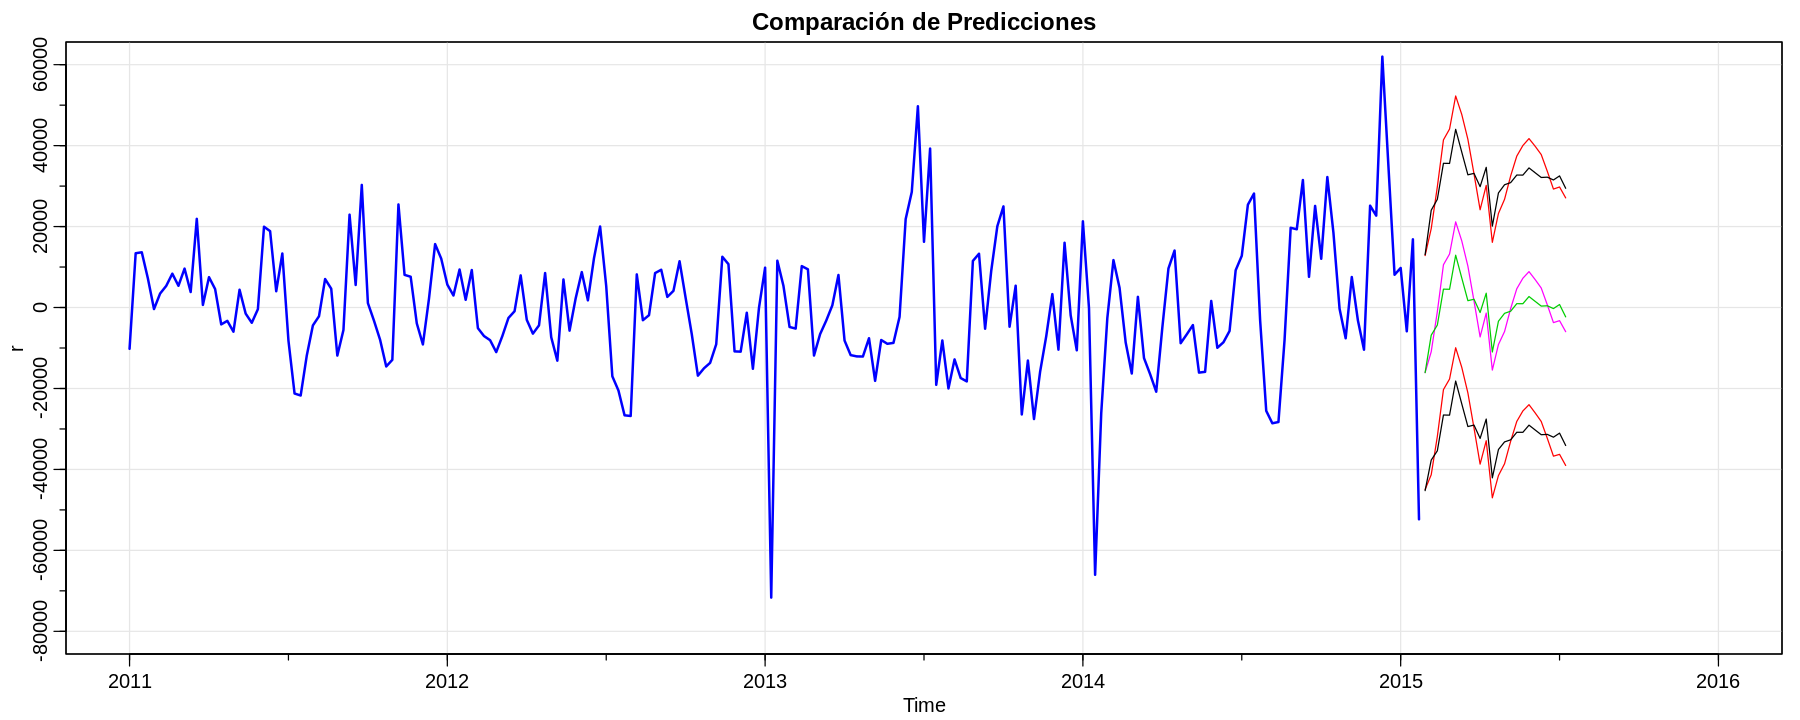

In [46]:
tsplot(r,xlim=c(2011,2016),ylim=c(-80000,60000), lwd=2, col=4, main="Comparación de Predicciones")
lines(prediccion1_media,col=6)
lines(prediccion1_lower,col=2)
lines(prediccion1_upper,col=2)
lines(prediccion2_media,col=3)
lines(prediccion2_lower,col=1)
lines(prediccion2_upper,col=1)

La siguiente gráfica contiene la predicción del ajuste de rampa y la predicción de los valores de la serie ventas. Dichos valores se calcularon sumando los del ajuste de regresión lineal más los valores de los residuos calculados con SARIMA

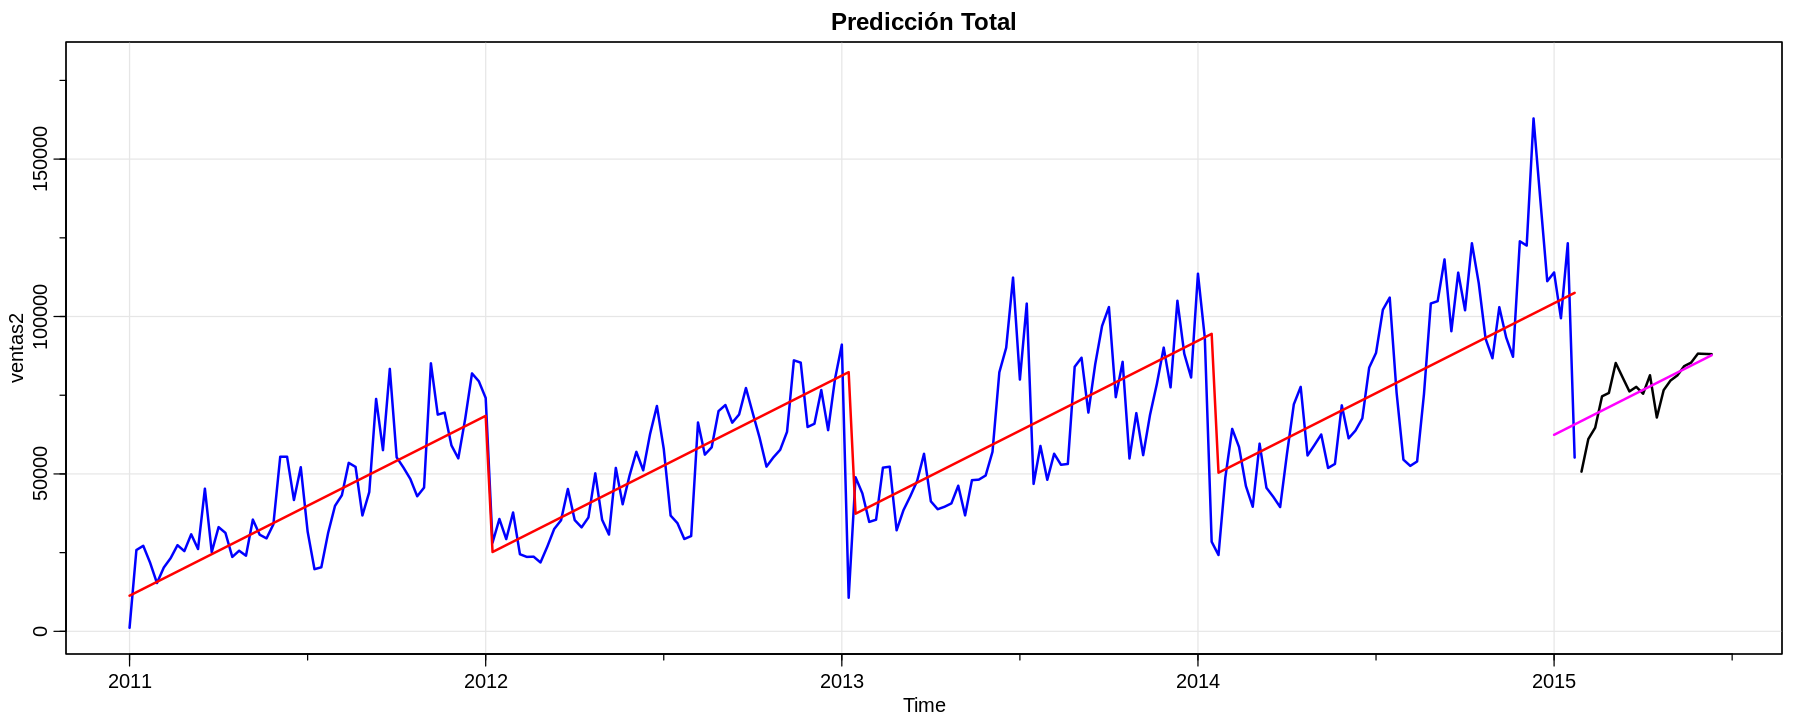

In [47]:
predicciont = prediccion + prediccion2_media
tsplot(ventas2,xlim=c(2011,2015.4615),ylim=c(0,180000), lwd=2, col=4, main="Predicción Total")
lines(ajuste,lwd=2, col=2)
lines(predicciont,lwd=2, col=1)
lines(prediccion,lwd=2, col=14)

## Correlación entre Variables

Analizaremos si existe correlación entre la variable ventas que hemos analizado hasta el momento y la variable descuento, para verificar si hay mayores ventas al tener mayor descuento.

In [48]:
ventas3 <- ventas %>%
group_by(año,semana) %>%
summarise(Total_Sales = sum(Sales),
Total_Discount = mean(Discount))

head(ventas3,3)

`summarise()` regrouping output by 'año' (override with `.groups` argument)



año,semana,Total_Sales,Total_Discount
<dbl>,<dbl>,<dbl>,<dbl>
2011,0,1122.783,0.1142857
2011,1,25827.283,0.1688387
2011,2,27169.672,0.1844602


In [49]:
V <- ts(ventas3$Total_Sales, start = 2011, frequency = 52)
D <- ts (ventas3$Total_Discount, start = 2011, frequency = 52)

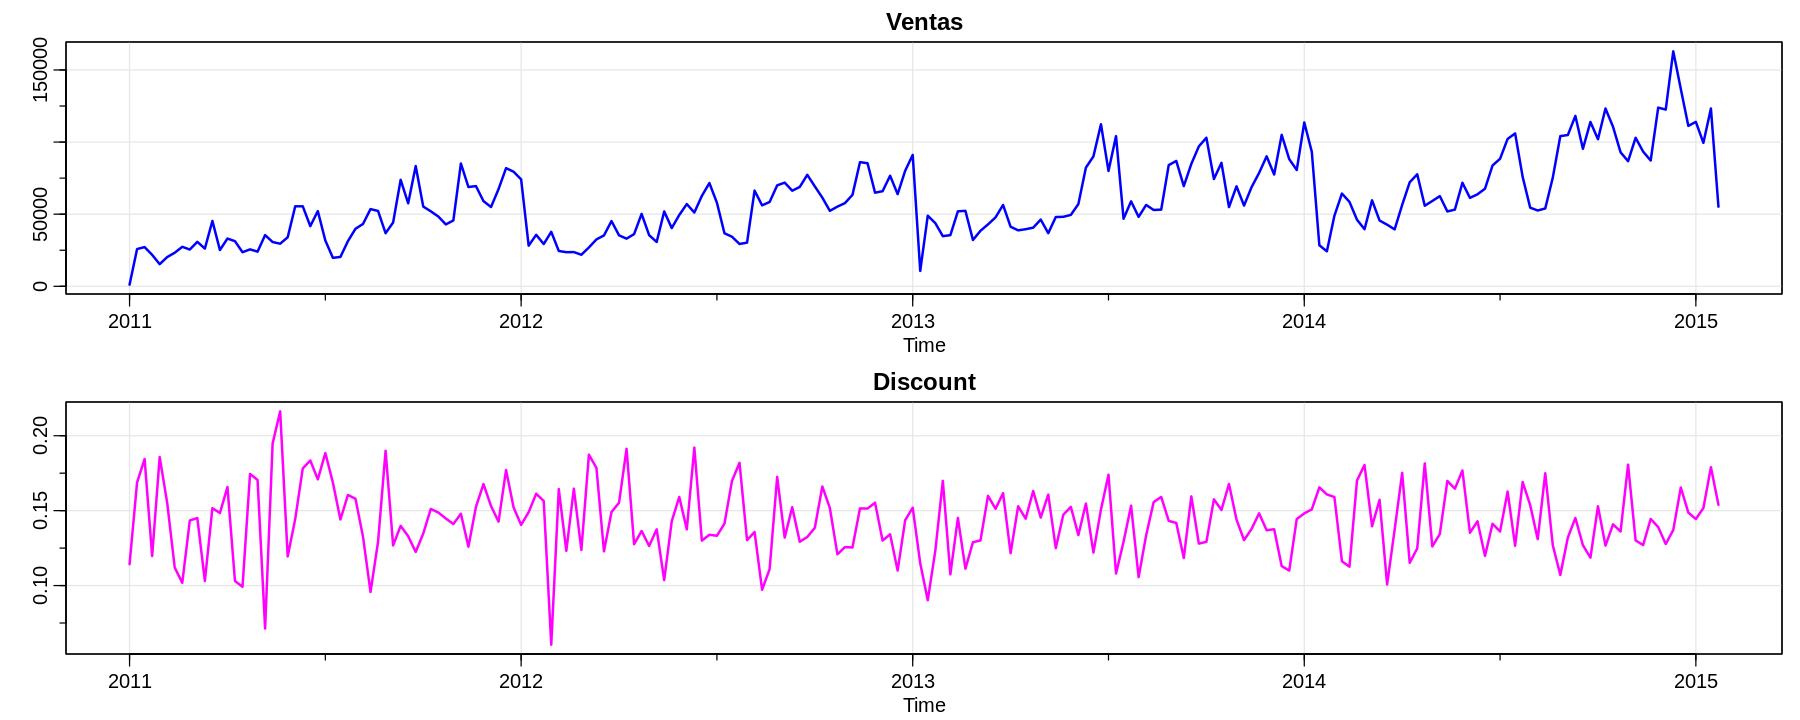

In [50]:
par(mfrow=c(2,1))
V=V;
D=D;

tsplot(V, main="Ventas", ylab="", lwd=2, col=4)
tsplot(D, main="Discount",  ylab="", lwd=2, col=6)

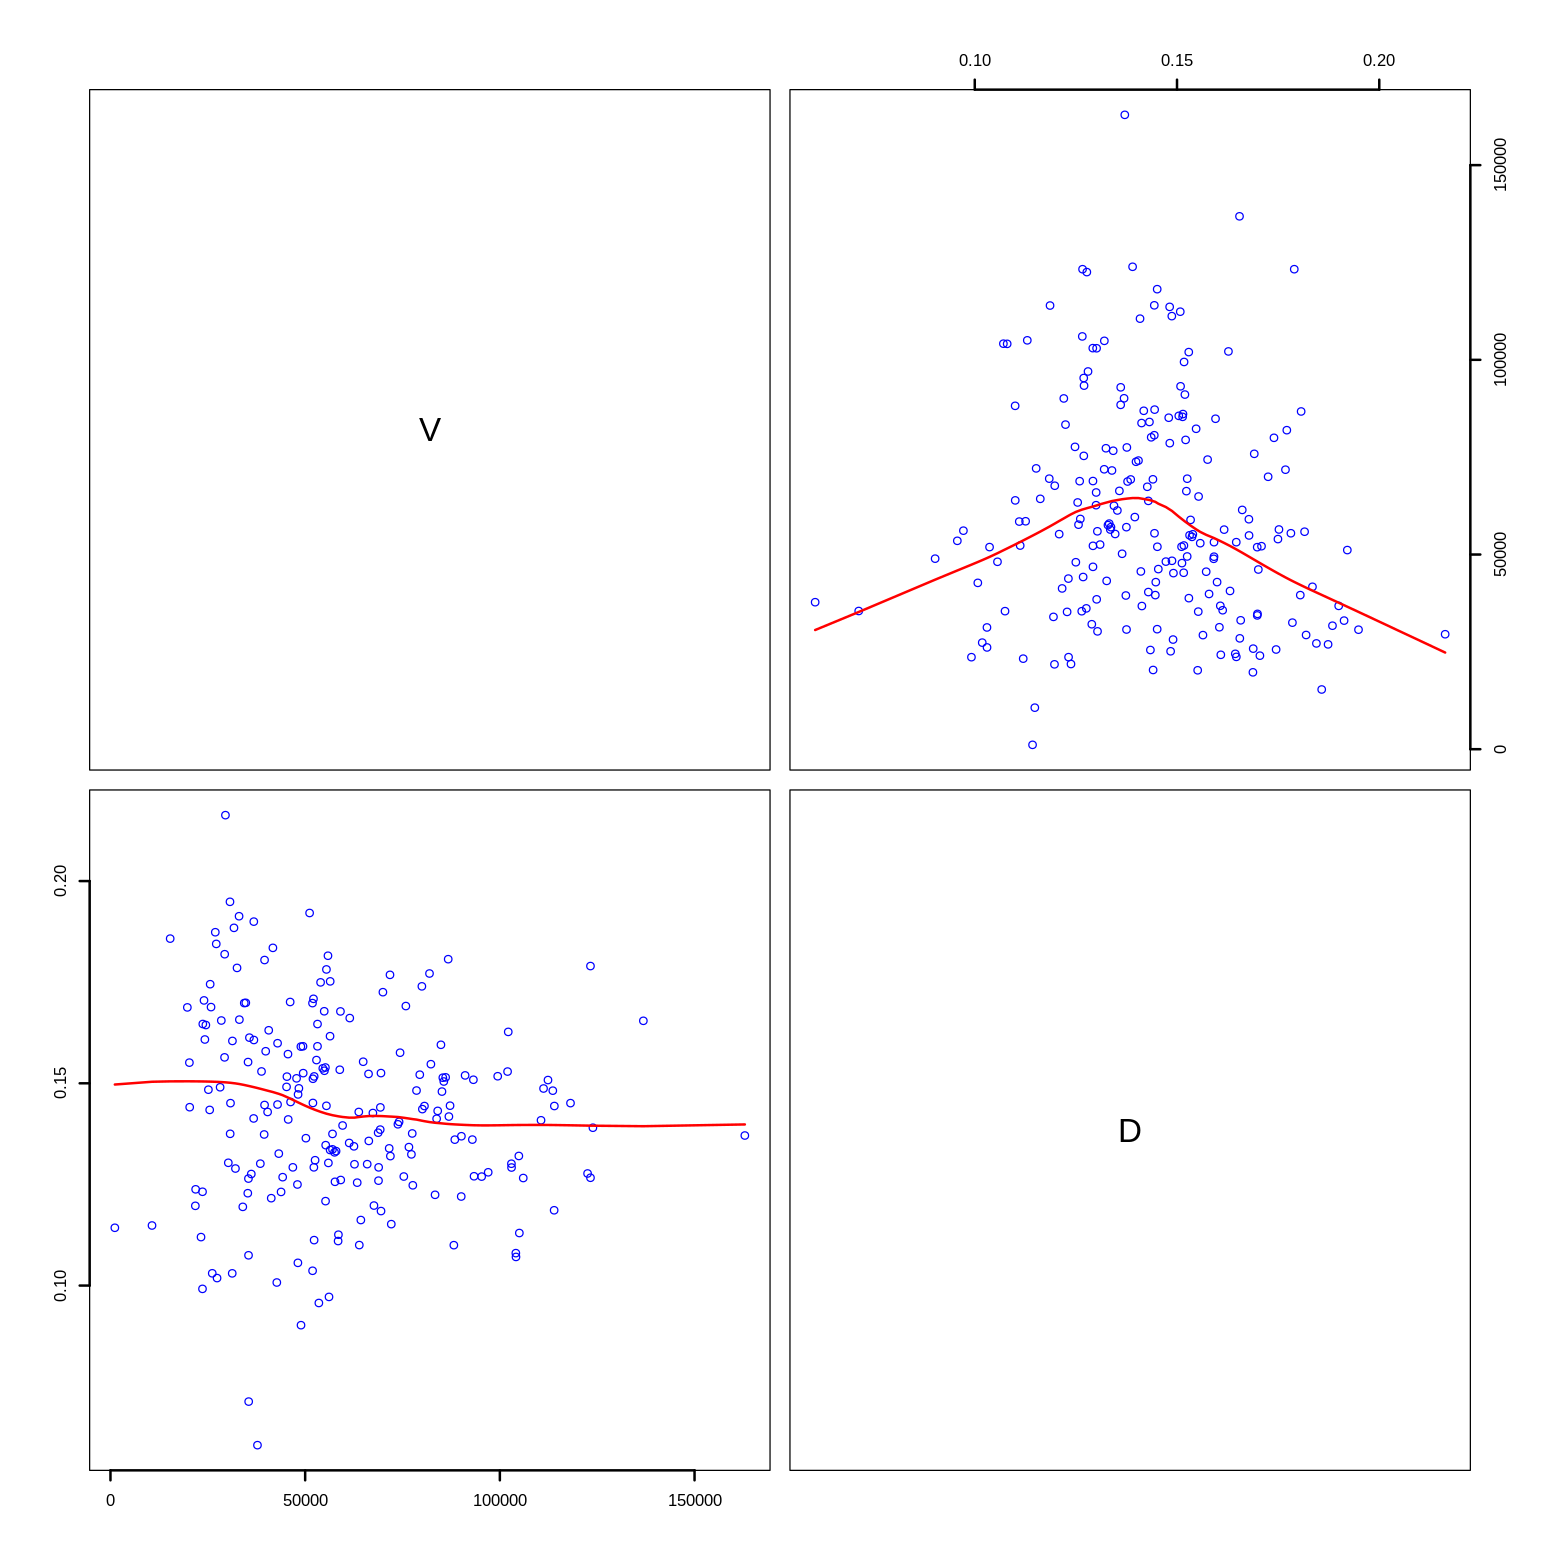

In [51]:
options(repr.plot.width=13, repr.plot.height=13)
pairs(cbind(V, D), col=4, panel=panel.smooth, lwd=2)

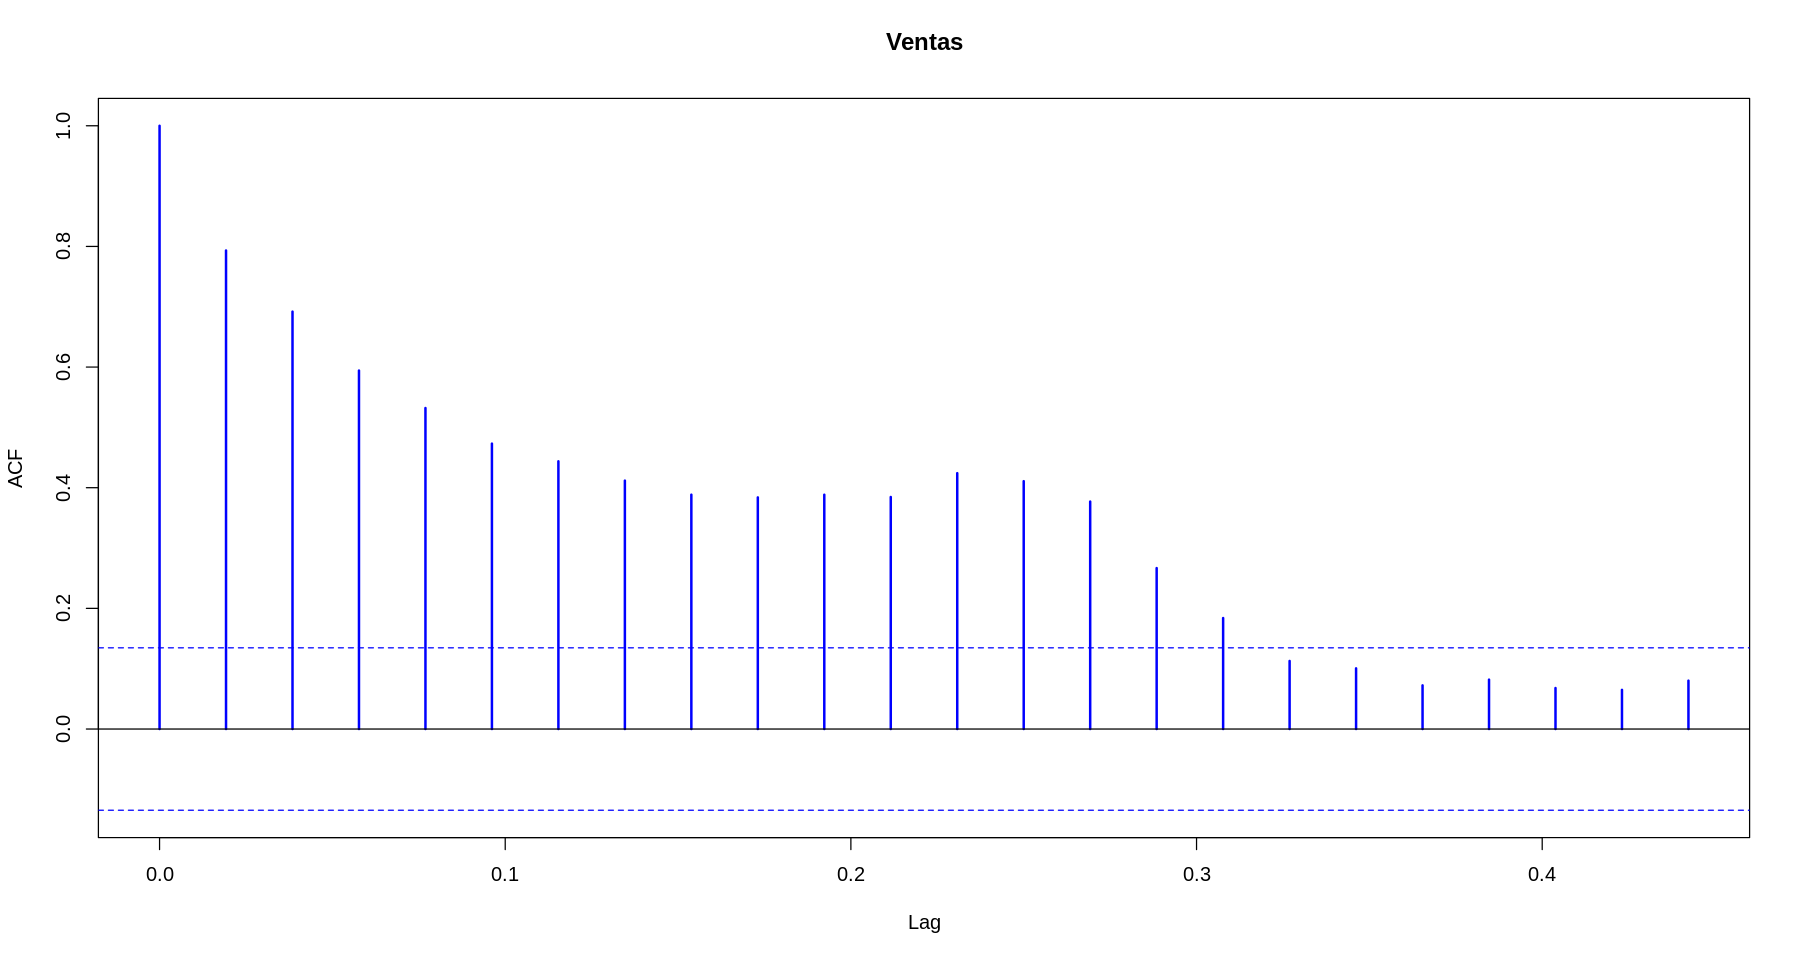

In [52]:
options(repr.plot.width=15, repr.plot.height=8)
acf(V, main="Ventas", col=4, lwd=2)

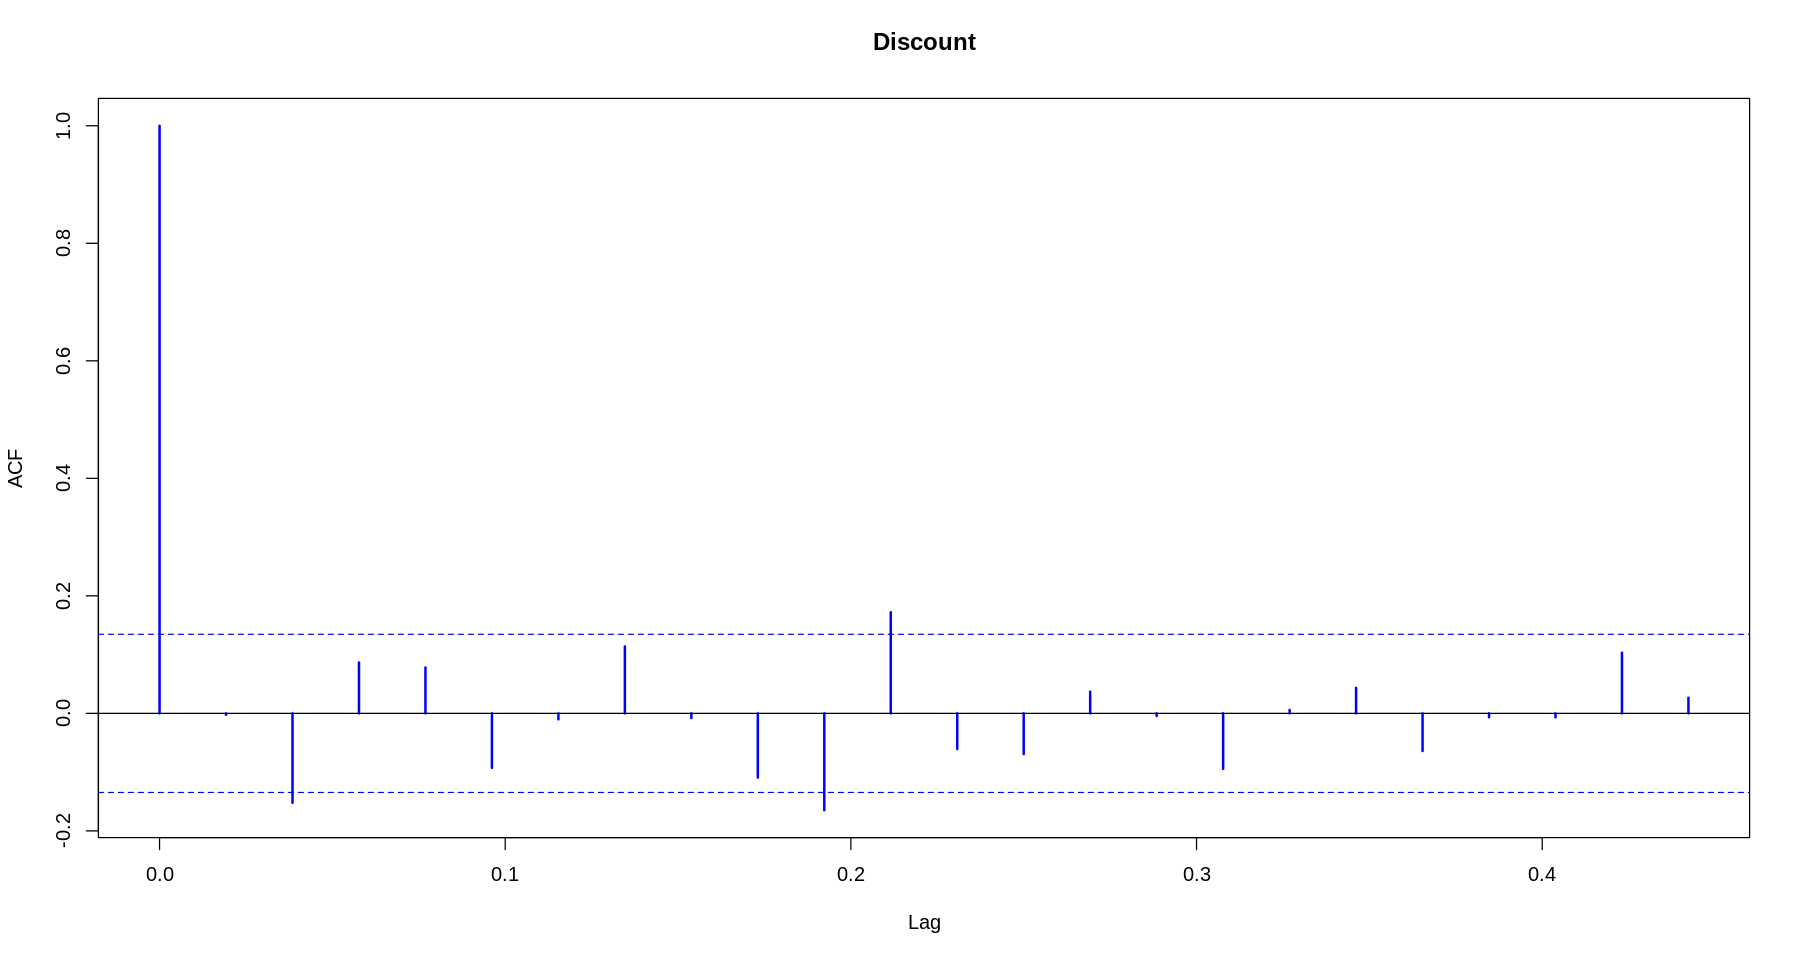

In [53]:
options(repr.plot.width=15, repr.plot.height=8)
acf(D, main="Discount", col=4, lwd=2)

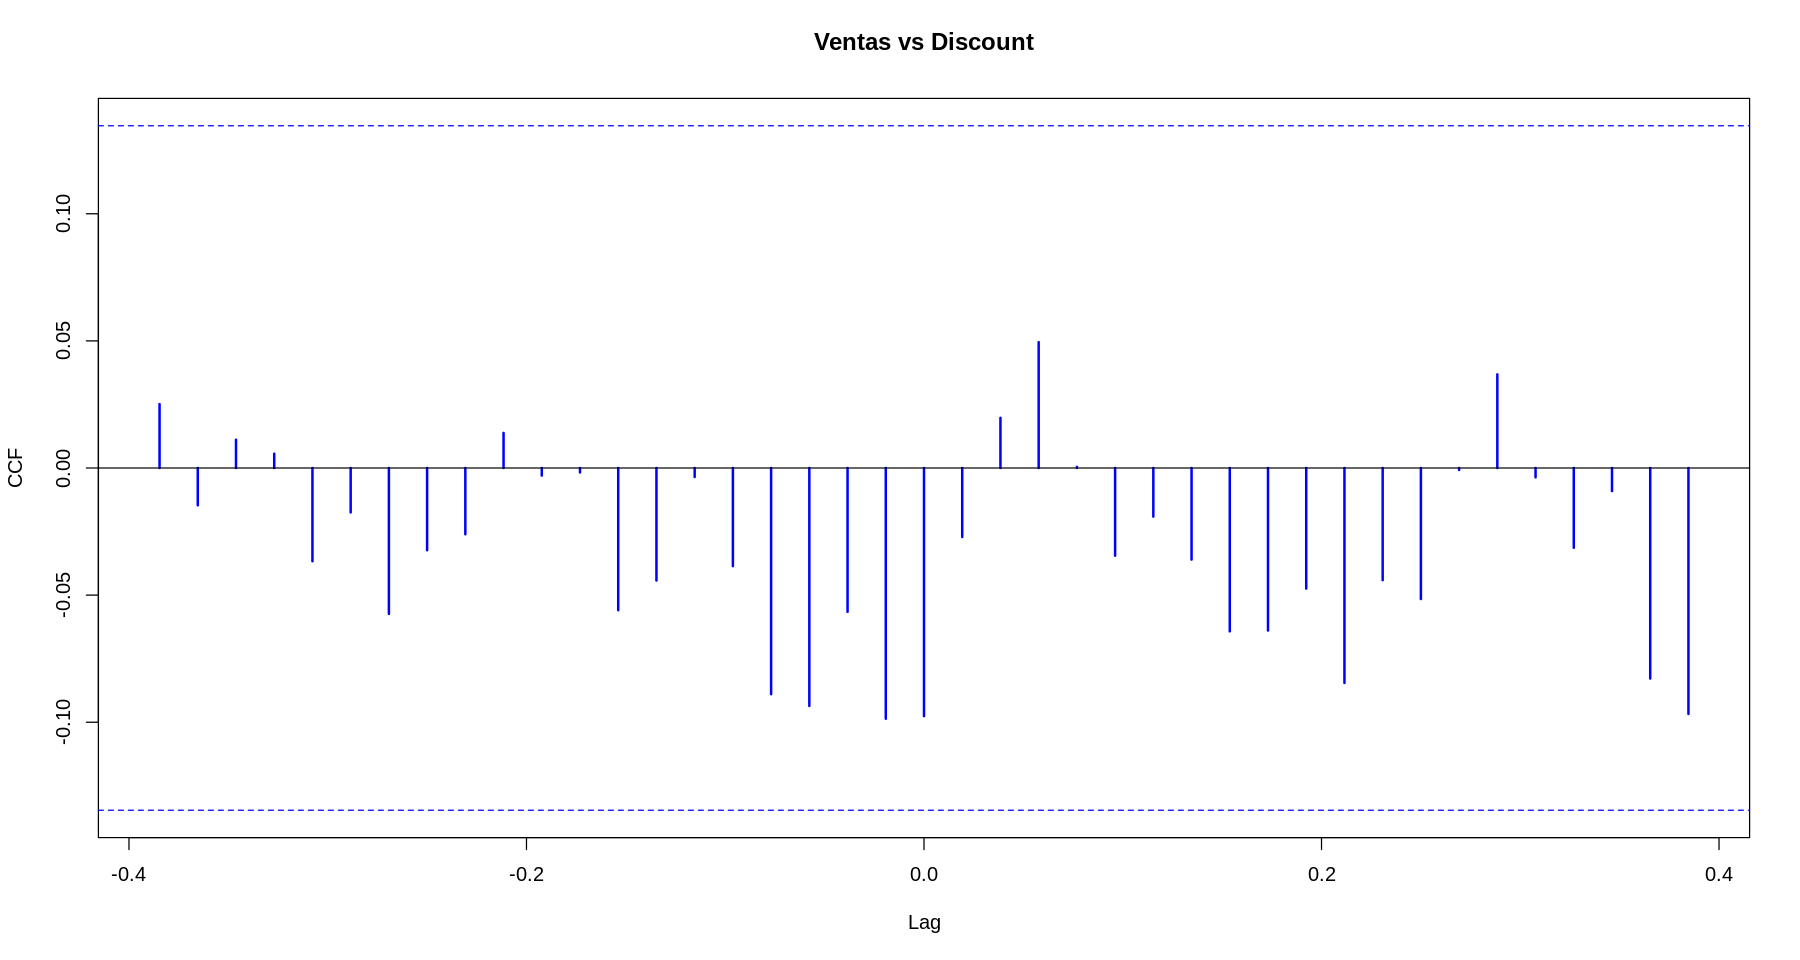

In [54]:
options(repr.plot.width=15, repr.plot.height=8)
ccf(D, V, main="Ventas vs Discount", ylab="CCF", col=4, lwd=2)

Analizando los resultados obtenidos podemos afirmar que no hay correlación entre las variables ventas y descuentos. Procederemos a estudiar la correlación con otra variable. Usaremos a continuación el Shipping Cost

In [55]:
ventas4 <- ventas %>%
group_by(año,semana) %>%
summarise(Total_Sales = sum(Sales),
Total_Scost = sum(Shipping.Cost))

head(ventas4,3)

`summarise()` regrouping output by 'año' (override with `.groups` argument)



año,semana,Total_Sales,Total_Scost
<dbl>,<dbl>,<dbl>,<dbl>
2011,0,1122.783,88.77
2011,1,25827.283,2534.90
2011,2,27169.672,3543.94


In [56]:
C <- ts(ventas4$Total_Scost, start = 2011, frequency = 52)

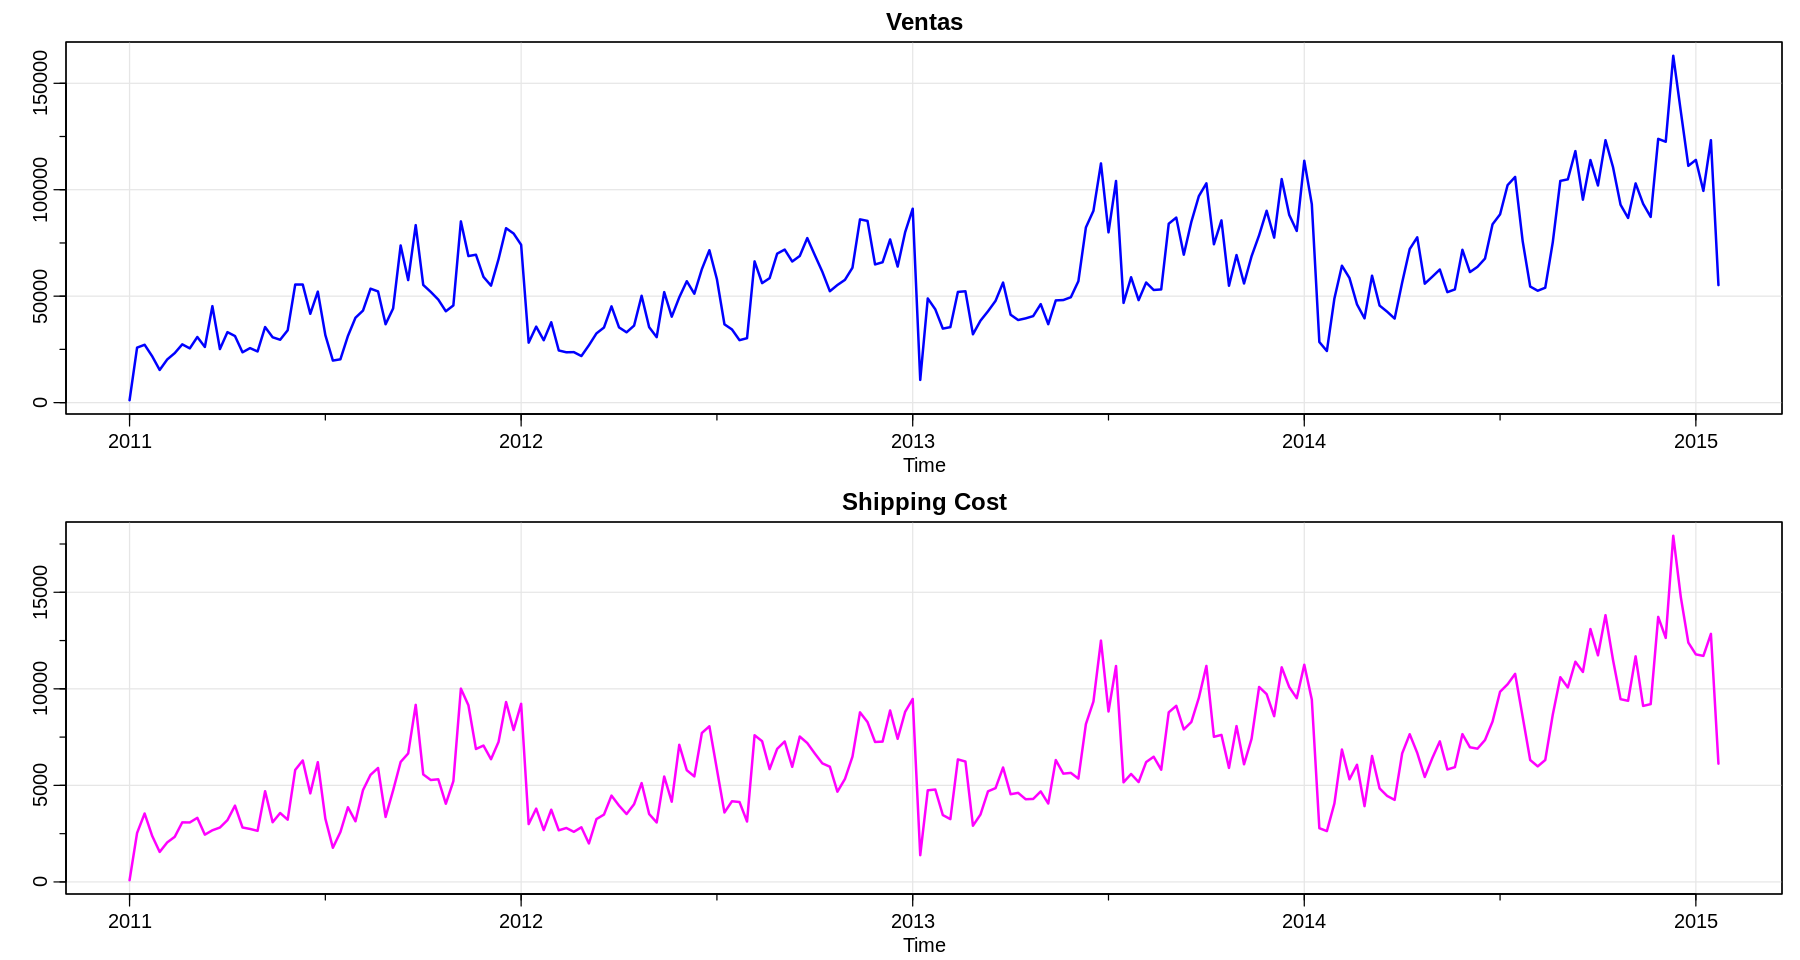

In [57]:
par(mfrow=c(2,1))
V=V;
C=C;

tsplot(V, main="Ventas", ylab="", lwd=2, col=4)
tsplot(C, main="Shipping Cost",  ylab="", lwd=2, col=6)

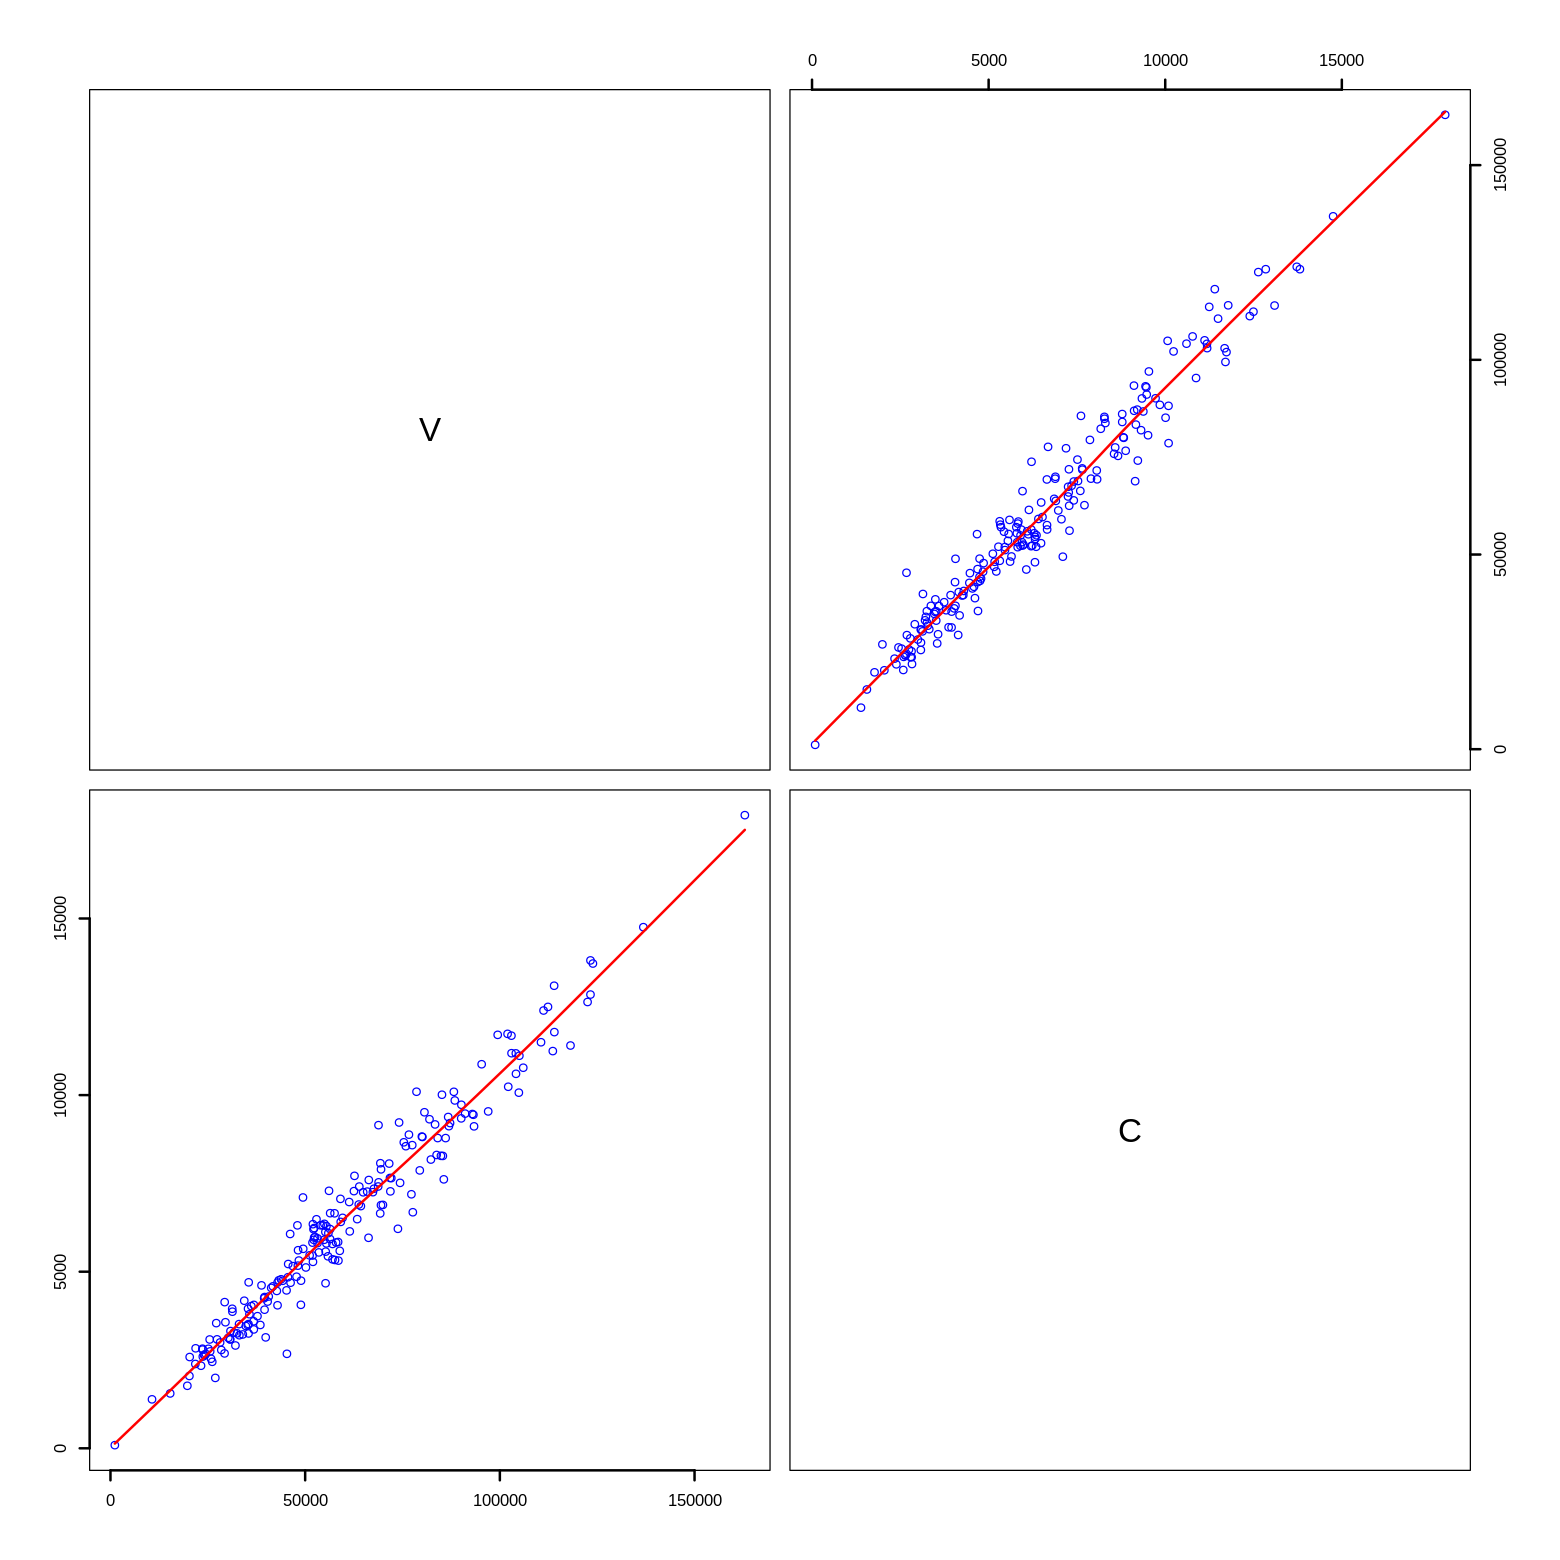

In [58]:
options(repr.plot.width=13, repr.plot.height=13)
pairs(cbind(V, C), col=4, panel=panel.smooth, lwd=2)

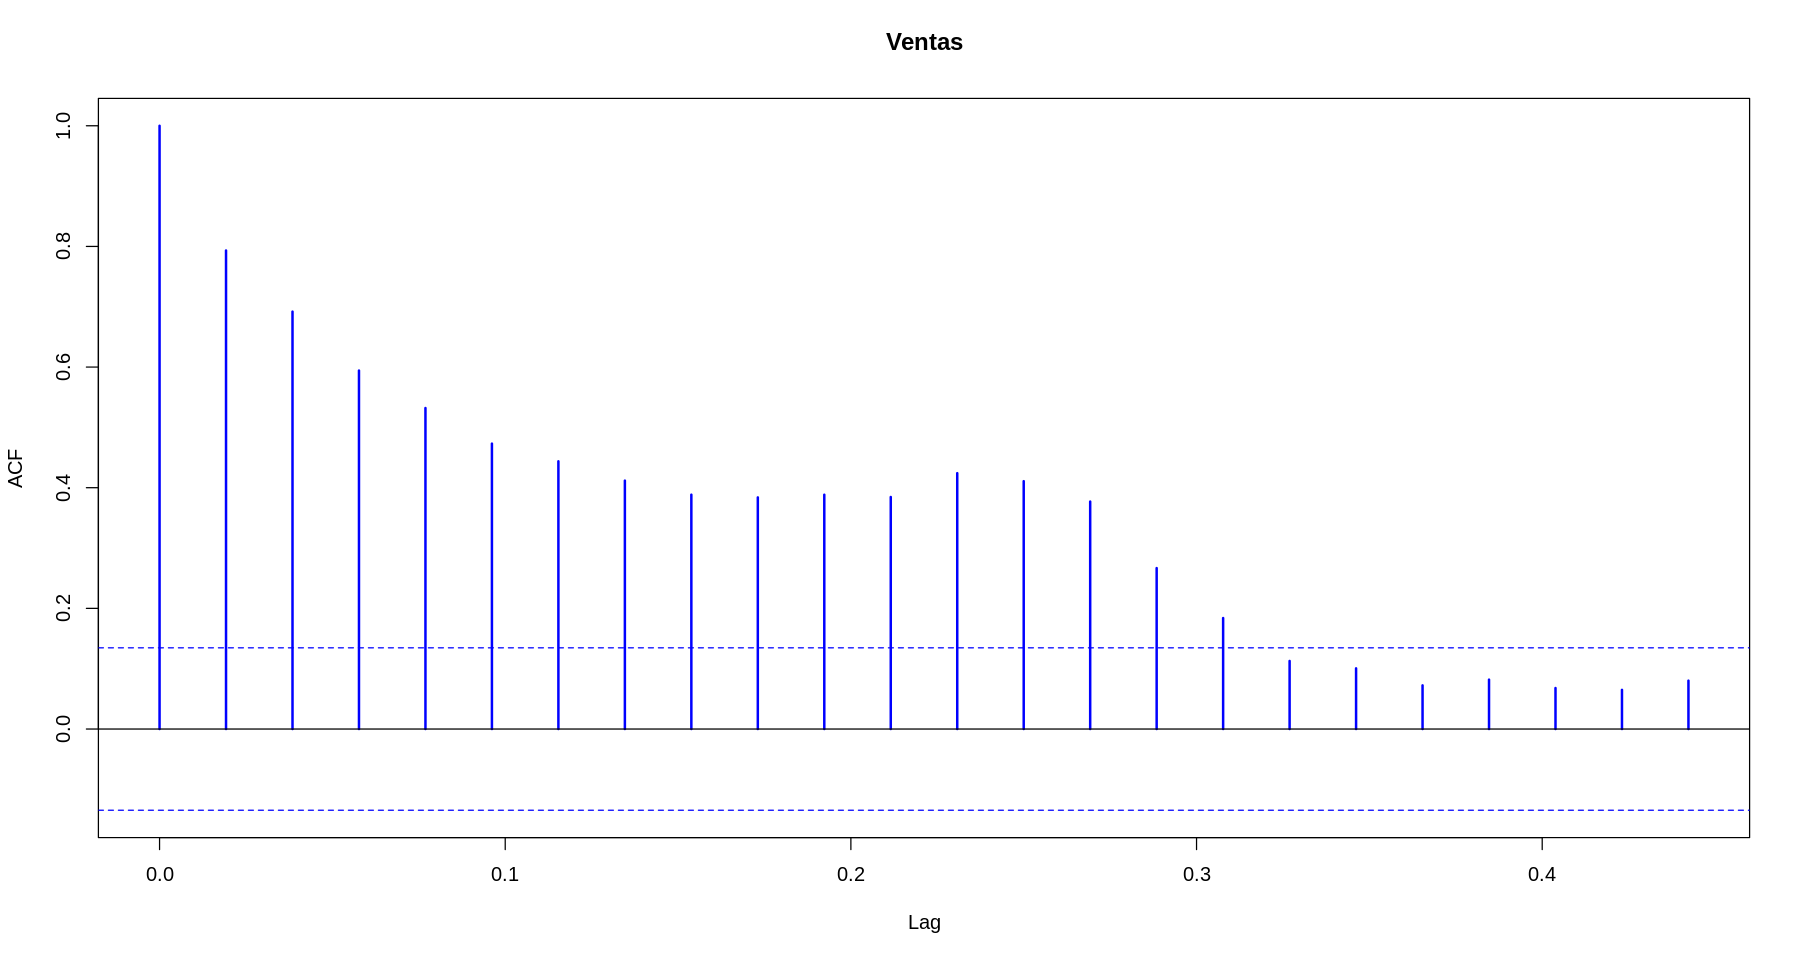

In [59]:
options(repr.plot.width=15, repr.plot.height=8)
acf(V, main="Ventas", col=4, lwd=2)

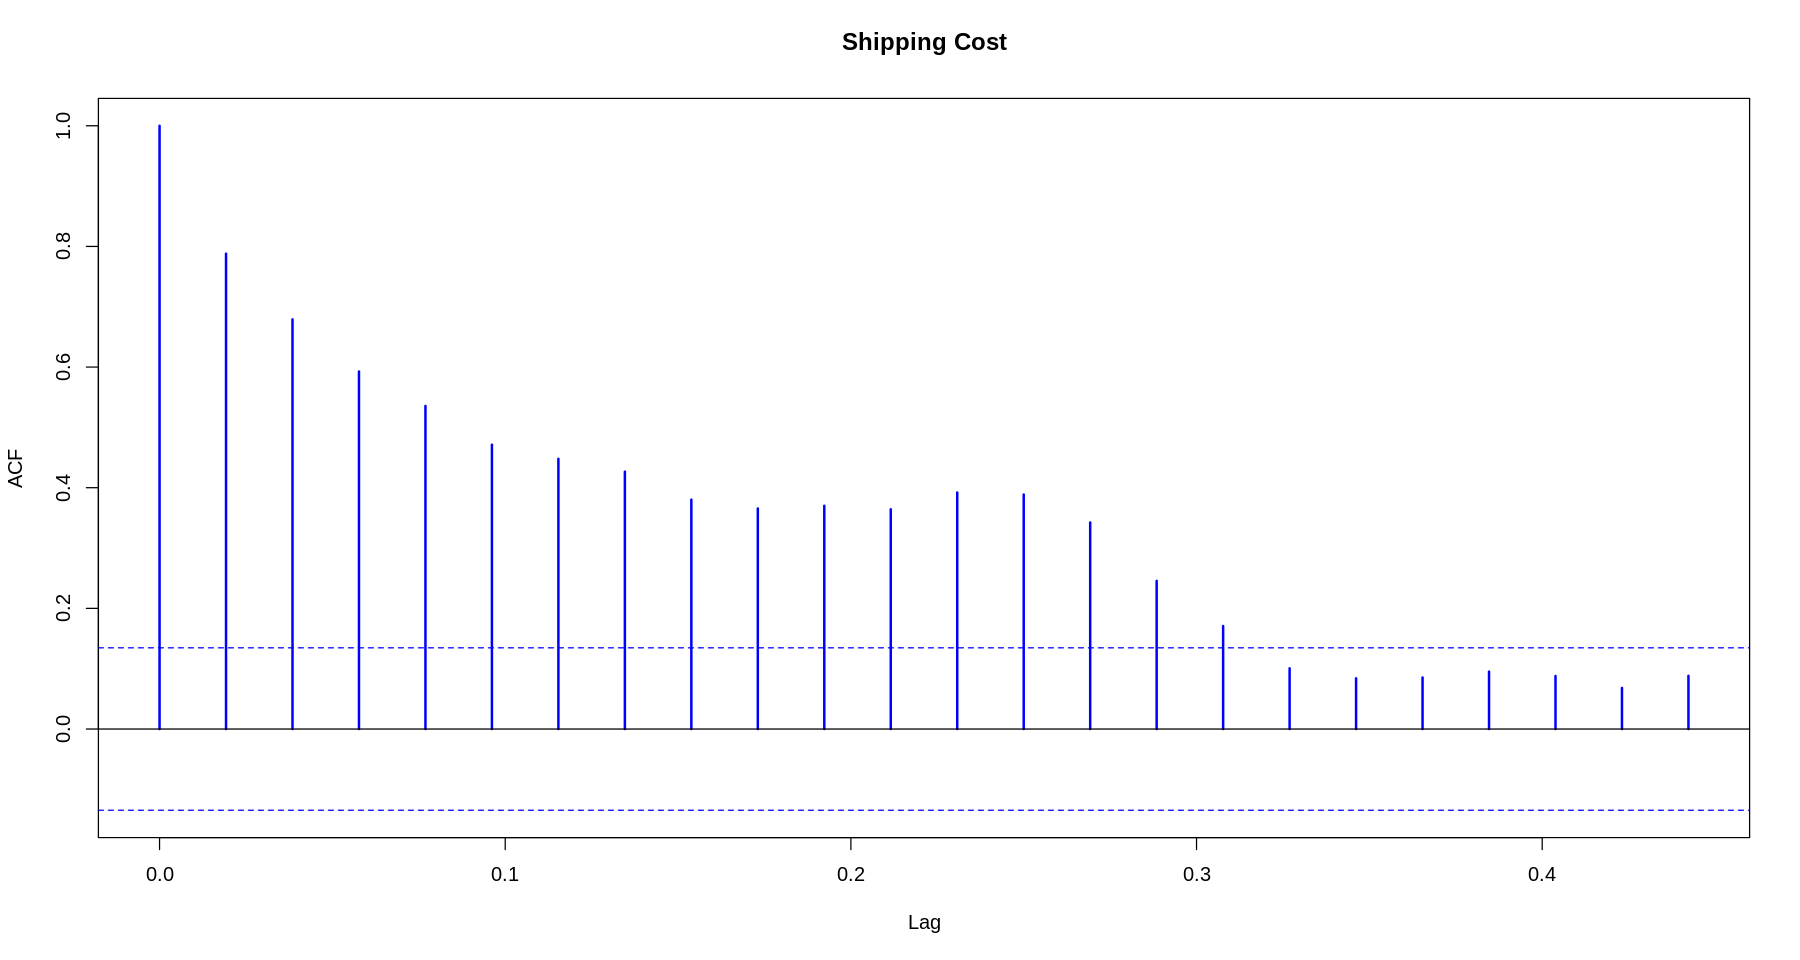

In [62]:
options(repr.plot.width=15, repr.plot.height=8)
acf(C, main="Shipping Cost", col=4, lwd=2)

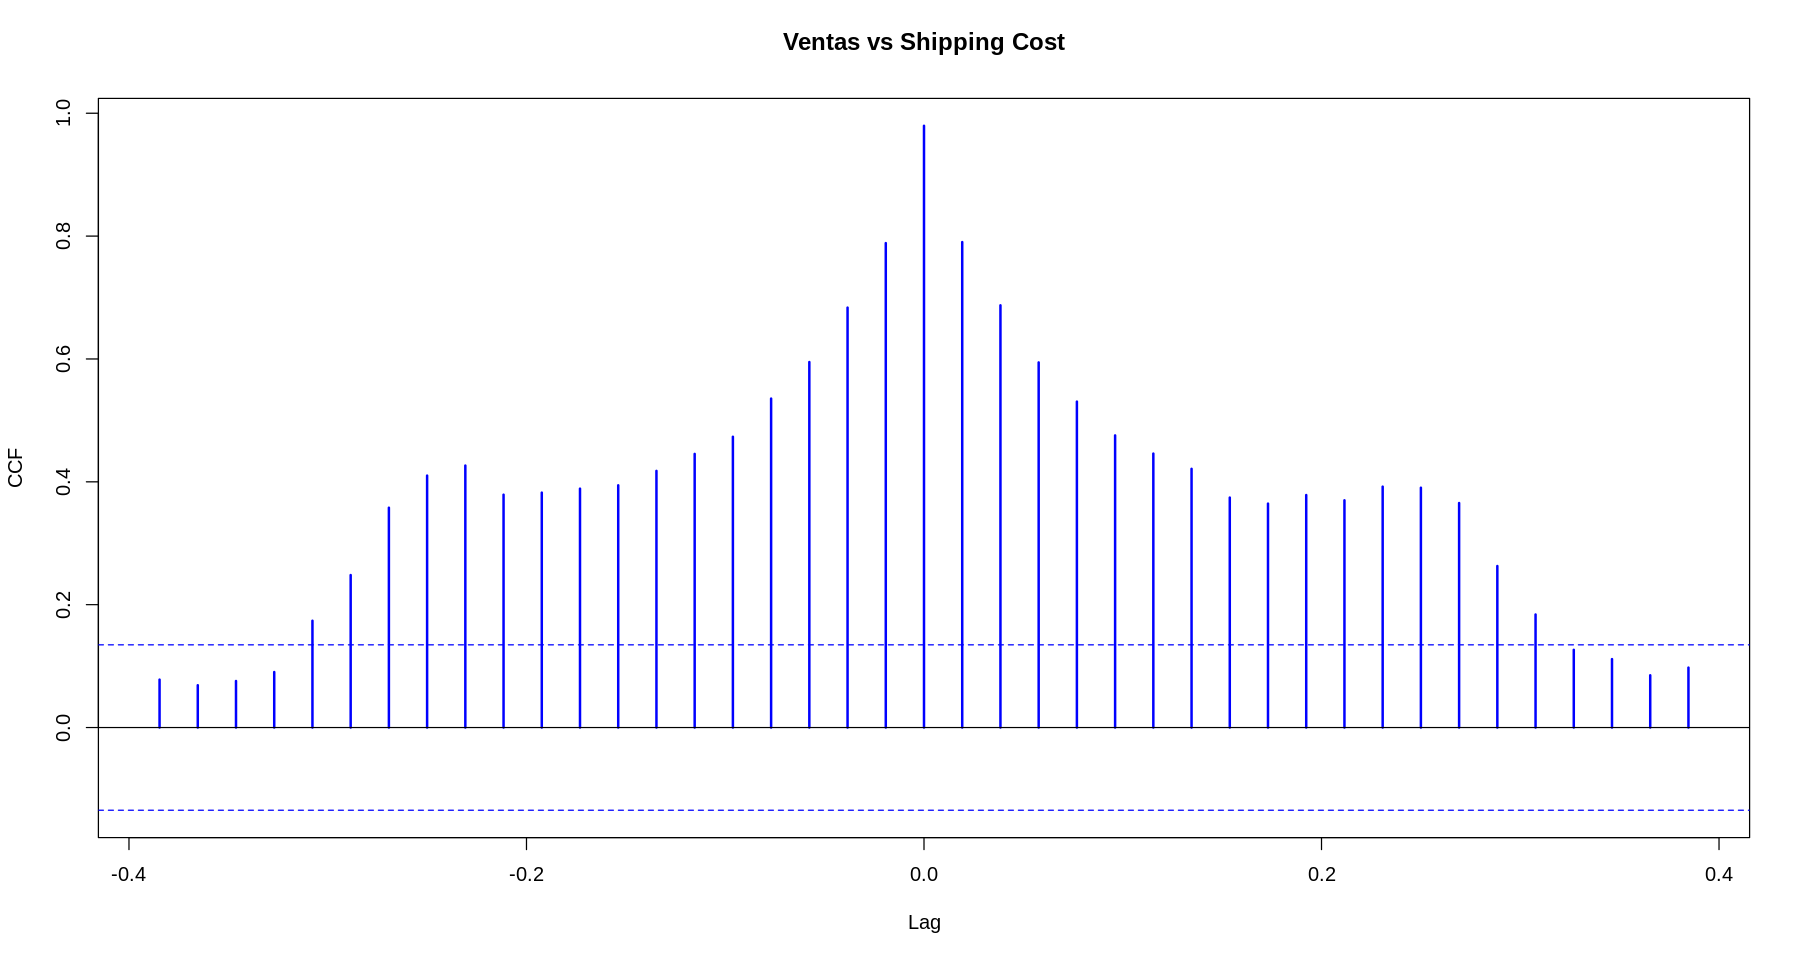

In [61]:
options(repr.plot.width=15, repr.plot.height=8)
ccf(V, C, main="Ventas vs Shipping Cost", ylab="CCF", col=4, lwd=2)

Podemos ver que el costo de envío (shipping cost) se comporta de manera similar a la ventas. Al hacer las gráficas de ACF visualizamos su comportamiento casi idéntico. Al hacer la correlación cruzada vemos que existe; es positiva y casi simétrica.
Podemos suponer que el costo de envío es calculado en base a un porcentaje de las ventas, en el entorno del 10% al ver los valores de los ejes de las gráficas de las "time series". 
Para verificar esta suposición haremos una regresión lineal entre las variables.

In [65]:
fit6 = lm(C~V)
summary(fit6)


Call:
lm(formula = C ~ V)

Residuals:
     Min       1Q   Median       3Q      Max 
-2186.26  -358.92    16.28   376.43  1802.11 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 50.012441  98.768735   0.506    0.613    
V            0.106167   0.001504  70.610   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 603.1 on 210 degrees of freedom
Multiple R-squared:  0.9596,	Adjusted R-squared:  0.9594 
F-statistic:  4986 on 1 and 210 DF,  p-value: < 2.2e-16


Al analizar los resultados, comprobamos que el costo de envío representa un 10% del valor de las ventas.